# FORECASTING OIL PRODUCTION USING LSTM MODELS

## PROJECT SUMMARY
This project investigates the use of Long Short-Term Memory (LSTM) neural networks to forecast monthly oil production rates for five wells, each exhibiting characteristic decline behaviour, operational variability, and seasonality. The analysis begins with a base LSTM model designed to learn temporal dependencies in the production data using fixed look-back windows and univariate sequences. The anticipated outcome is that the base LSTM will capture the general decline trend and short-term fluctuations reasonably well, providing a benchmark against which more complex architectures can be evaluated.

To ensure that the model is both interpretable and robust, the workflow includes a systematic exploration of the data, followed by rigorous model training and evaluation. Exploratory data analysis (EDA) examines statistical distributions, decline patterns, autocorrelation structure, and month-to-month percent changes to better understand the behaviour of each well. The modeling workflow then uses a rolling time-series train/test split, normalization, and engineered look-back sequences to fit the LSTM. Model performance is quantified using RMSE on both training and test sets, and hyperparameter optimization is conducted with Optuna, enabling a structured search over look-back windows, learning rates, dropout, and LSTM node counts for each well.

Beyond the base LSTM, the project evaluates three additional architectures to determine whether enhanced sequence modeling capacity improves predictive accuracy. A bidirectional LSTM is used to test whether processing sequences in both forward and backward directions provides richer temporal context. A stacked LSTM adds depth by layering multiple LSTM units, allowing the model to extract more abstract temporal features. Finally, a CNN-LSTM hybrid model introduces convolutional layers to detect short-term local patterns before passing the extracted features into an LSTM for long-term dependency learning. Together, these models enable a comprehensive comparison of LSTM-based forecasting approaches for oil production.

## DATA SOURCE & IMPORT

#### Data Source

- The datasets used in this project are a combination of production data for five crude oil wells and commodity pricing data.
- **Production Data**
  - The historical production data has been provided directly by a small Canadian oil and gas producer.  
  - *Reference*: Private Operator (Anonymous). (2025). Internal oil well production dataset: Five wells in Western Canada.
- **Commodity Pricing Data**
  - Historical crude oil and natural gas commodity pricing data is downloaded from a trusted Canadian petroleum reserve evaluator.
  - *Reference*: McDaniel & Associates Consultants Ltd. (2025, October 1). Price forecasts [Web page]. https://mcdan.com/price-forecasts/

#### Import Python Libraries

In [259]:
# Import core analysis, visualization, and statistical libraries used throughout the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pathlib import Path
import random
import itertools
import json
import requests
import warnings
import logging
from IPython.display import display

import pandas as pd
import numpy as np

from io import StringIO
from textwrap import fill
from fake_useragent import UserAgent

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.io as pio
pio.renderers = 'plotly_mimetype+notebook+iframe'
# pio.renderers.default = 'vscode'  # or "notebook", "plotly_mimetype", etc.

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
import tensorflow as tf
from tensorflow import keras
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_parallel_coordinate

# Silence warnings
alt.data_transformers.disable_max_rows()
warnings.filterwarnings('ignore', category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Set seeds
seed = 666
np.random.seed(seed)
random.seed(seed)

keras.utils.set_random_seed(seed)

# Define model constants
SCALING_FACTOR = 1e-6 # Log transform scaling factor to ensure zero values are handled correctly
SPLIT_RATIO = 0.8     # Train-test or train-validation split ratio
EPOCHS = 100          # Number of epochs to train models over
BATCH_SIZE = 1        # Standard LSTM batch size
PATIENCE = 10         # Early stopping level of patience
N_TRIALS = 30         # Number of hyperparameter tuning trails to conduct

#### Import Production Data
- Production data has been provided directly from the oil company in a `.csv` file.

In [260]:
# Import production dataset file (as provided by the private oil company)
prod_df = pd.read_csv('prod.csv')

# Convert date column to datetime
prod_df['date'] = pd.to_datetime(prod_df['date'])

# Display production dataframe
prod_df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  
0                          5068.647059                          1439.235294  
1                          5106.848967                           388.769475  
2                          9696.032301                           335.224764  
3                         10888.633330                           119.500000  
4                          7586.517241                           169.172414  
..                                 ...                                  ...  
485                        1446.741935                            48.709677  
486                          35.300000                           104.833333  
487                          45.580645                            24.354839  
488                          70.600000                            25.200000  
489                         188.333333                           264.166667  

[490 rows x 6 columns]

#### Import Commodity Pricing Data
- Commodity price data in `json` format is extracted directly from the McDaniel's website.

In [261]:
# Function to load the commodity price json file and convert it into a dataframe
def import_price_data(url):
    response = requests.get(url, headers={'User-Agent': UserAgent().random})

    data = json.loads(response.content)

    rows = []
    for entry in data:
        date = entry['date']
        row = {'date': date}
        for item in entry['values']:
            base_key = item['key'].replace(' Forecast', '').strip()
            row[f'{base_key}'] = item['usd']
        rows.append(row)
    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(df['date'])
    return df

# Define the url links to the pricing data
oil_url = 'https://mcdan.com/forecast/data/oil.json'
gas_url = 'https://mcdan.com/forecast/data/gas.json'

# Create oil and natural gas pricing datasets
oil_prices_df = import_price_data(oil_url)
gas_prices_df = import_price_data(gas_url)

# Define prod_df min/max dates
prod_min_date = prod_df['date'].min()
prod_max_date = prod_df['date'].max()

# Filter oil_prices_df and gas_prices_df by prod_min_date and prod_max_date
oil_prices_df = oil_prices_df[(oil_prices_df['date']>=prod_min_date) & (oil_prices_df['date']<=prod_max_date)]
gas_prices_df = gas_prices_df[(gas_prices_df['date']>=prod_min_date) & (gas_prices_df['date']<=prod_max_date)]

#### Merge Production & Pricing Datasets
- Create the final dataset used for evaluation

In [262]:
# Merge the prod_df, oil_prices_df, and gas_prices_df
df = prod_df.merge(oil_prices_df).merge(gas_prices_df)

# Display combined dataset
df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  \
0                          5068.647059                          1439.235294   
1                          5106.848967                           388.769475   
2                          9696.032301                           335.224764   
3                         10888.633330                           119.500000   
4                          7586.517241                           169.172414   
..                                 ...                                  ...   
485                        1446.741935                            48.709677   
486                          35.300000                           104.833333   
487                          45.580645                            24.354839   
488                          70.600000                            25.200000   
489                         188.333333                           264.166667   

       WTI   BRENT    EDM    WCS    HH  AECO  STA2  
0    94.83  112.16  88.10  62.09  3.33  3.18  3.08  
1    95.32  116.02  87.12  58.36  3.33  3.03  2.84  
2    92.96  108.56  86.95  66.71  3.81  2.96  2.79  
3    92.07  102.25  89.04  68.79  4.17  3.39  3.18  
4    94.80  102.56  93.55  81.07  4.04  3.63  3.42  
..     ...     ...    ...    ...   ...   ...   ...  
485  69.98   76.98  64.06  53.40  2.83  0.56  0.66  
486  67.87   74.41  61.23  52.79  2.94  0.56  0.57  
487  70.98   74.25  63.18  52.85  2.79  1.18  1.16  
488  68.06   72.53  64.93  48.91  2.91  1.58  1.08  
489  70.23   78.89  61.94  40.84  2.90  1.05  1.04  

[490 rows x 13 columns]

## DATA SUMMARY

#### Dataset Shape & Data Types
- Investigating the number of rows and columns contained in the dataset, and the types of data found in each column.

In [263]:
# Dataset shape
(rows, cols) = df.shape
print(f'The dataset has {rows:,} rows and {cols} columns.\n')

# Dataset data types
df.info()

The dataset has 490 rows and 13 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   well_name                            490 non-null    object        
 1   date                                 490 non-null    datetime64[ns]
 2   production_hours                     490 non-null    int64         
 3   oil_producing_daily_avg (bbl/day)    490 non-null    float64       
 4   gas_producing_daily_avg (mcf/day)    490 non-null    float64       
 5   water_producing_daily_avg (bbl/day)  490 non-null    float64       
 6   WTI                                  490 non-null    float64       
 7   BRENT                                490 non-null    float64       
 8   EDM                                  490 non-null    float64       
 9   WCS                                  490 non-

#### Feature Descriptions
- The dataset contains a combination of production rates and commodity pricing streams.

Feature | Description | Units | Data Type
---|---|---|---
**well_name** | Name of the producing well | | Categorical
**date** | First day of each month of production | dd/mm/yyy | Datetime
**production_hours** | Number of producing hours a well is on production in a month | hours | Numeric
**oil_producing_daily_avg (bbl/day)** | Monthly average of the daily oil production rate | bbl/d | Numeric
**gas_producing_daily_avg (mcf/day)** | Monthly average of the daily natural gas production rate | mcf/d | Numeric
**water_producing_daily_avg (bbl/day)** | Monthly average of the daily water production rate | bbl/d | Numeric
**WTI** | Monthly average of the West Texas Intermediate crude oil benchmark price | US $/bbl | Numeric
**BRENT** | Monthly average of the Brent crude oil benchmark price | US $/bbl | Numeric
**EDM** | Monthly average of the Edmonton Light Sweet crude oil benchmark price | US $/bbl | Numeric
**WCS** | Monthly average of the Western Canadian Select crude oil benchmark price | US $/bbl | Numeric
**HH** | Monthly average of the Henry Hub natural gas benchmark price | US $/mcf | Numeric
**AECO** | Monthly average of the AECO natural gas benchmark price | US $/mcf | Numeric
**STA2** | Monthly average of the BC Station 2 natural gas benchmark price | US $/mcf | Numeric

> - For this project **the target variable is the `oil_producing_daily_avg (bbl/day)`** column at time $t+1$.

## EDA
The EDA section presents monthly production trends by well, blends in macro indicators, and highlights shut-in periods to reveal The EDA section traces monthly production trends for every well, overlaying macro pricing indicators and shut-in periods to surface operational cycles, sudden changes, and downtime. It also frames the upcoming train/test split within that historical context, so the LSTM preparation later clearly ties back to the exploratory insights.

#### Frequency of Categorical Columns
- Each well has produced for a different length of time, where each row in the dataset represents a month of production.
- It would be interesting to visualize the difference between the first and last day of production by counting the row occurrences in the `well_name` column.

In [264]:
# Visualize months on production
alt.Chart(df).mark_bar().encode(
    alt.X('well_name:N').title(None),
    alt.Y('count():Q').title(None),
    alt.Color('well_name').scale(scheme='viridis')
).properties(
    height = 300,
    width = 500,
    title=alt.Title('Months on Production by Well', fontSize=20, align='right'),
)

alt.Chart(...)

#### Distributions of Numeric Columns
- These are used to visualize how numeric columns are distributed, and to observe any patterns or outliers in the dataset.

In [265]:
# Function to plot a set of histograms for a subset of columns
def plot_numeric_histograms(input_df, subset, chart_title, col_count):
    # Melt the numeric columns into one column
    df_melt = input_df[subset].melt(var_name='feature', value_name='value')

    # Create a base Altair histogram chart
    base_chart = alt.Chart(df_melt).mark_bar(opacity=1, binSpacing=0).encode(
        alt.X('value:Q').axis(title=None).bin(maxbins=50),
        alt.Y('count():Q').axis(title=None).stack(None),
        color = alt.Color('feature:N').scale(scheme='viridis').sort(df.columns).legend(None)
    ).properties(
        width=750 / col_count,
        height=150
    )

    # Display a histogram for each numeric_columns
    chart = alt.ConcatChart(
        title=alt.Title(f'{chart_title}', fontSize=20),
        concat=[base_chart.transform_filter(alt.datum.feature == value).properties(title=value) for value in subset],
        columns=col_count,
    ).configure_title(
        fontSize=10
    ).resolve_axis(
        x='independent',
        y='independent'
    ).resolve_scale(
        x='independent', 
        y='independent'
    )

    return chart

# Define numeric feature columns
numeric_columns = [col for col in df.columns.to_list() if col not in ['well_name','date']]

# Plot numeric histograms
plot_numeric_histograms(df, numeric_columns, 'Numeric Columns Data Distributions', 3)

alt.ConcatChart(...)

> - The `oil_producing_daily_avg (bbl/day)` and `water_producing_daily_avg (bbl/day)` columns seem to be somewhat exponentially distributed, whereas the `gas_producing_daily_avg (mcf/day)` column has more variation and looks to be a skewed distribution.
> - The crude oil commodity prices (`WTI`, `BRENT`, `EDM`, `WCS`) all seem to have bi-modal distributions indicating that those prices may experience periods of high and low price environments.

#### Numeric Columns Pairplot
- This pairplot visualizes the scatterplots and histograms that reveals how production metrics and pricing indicators move together across wells

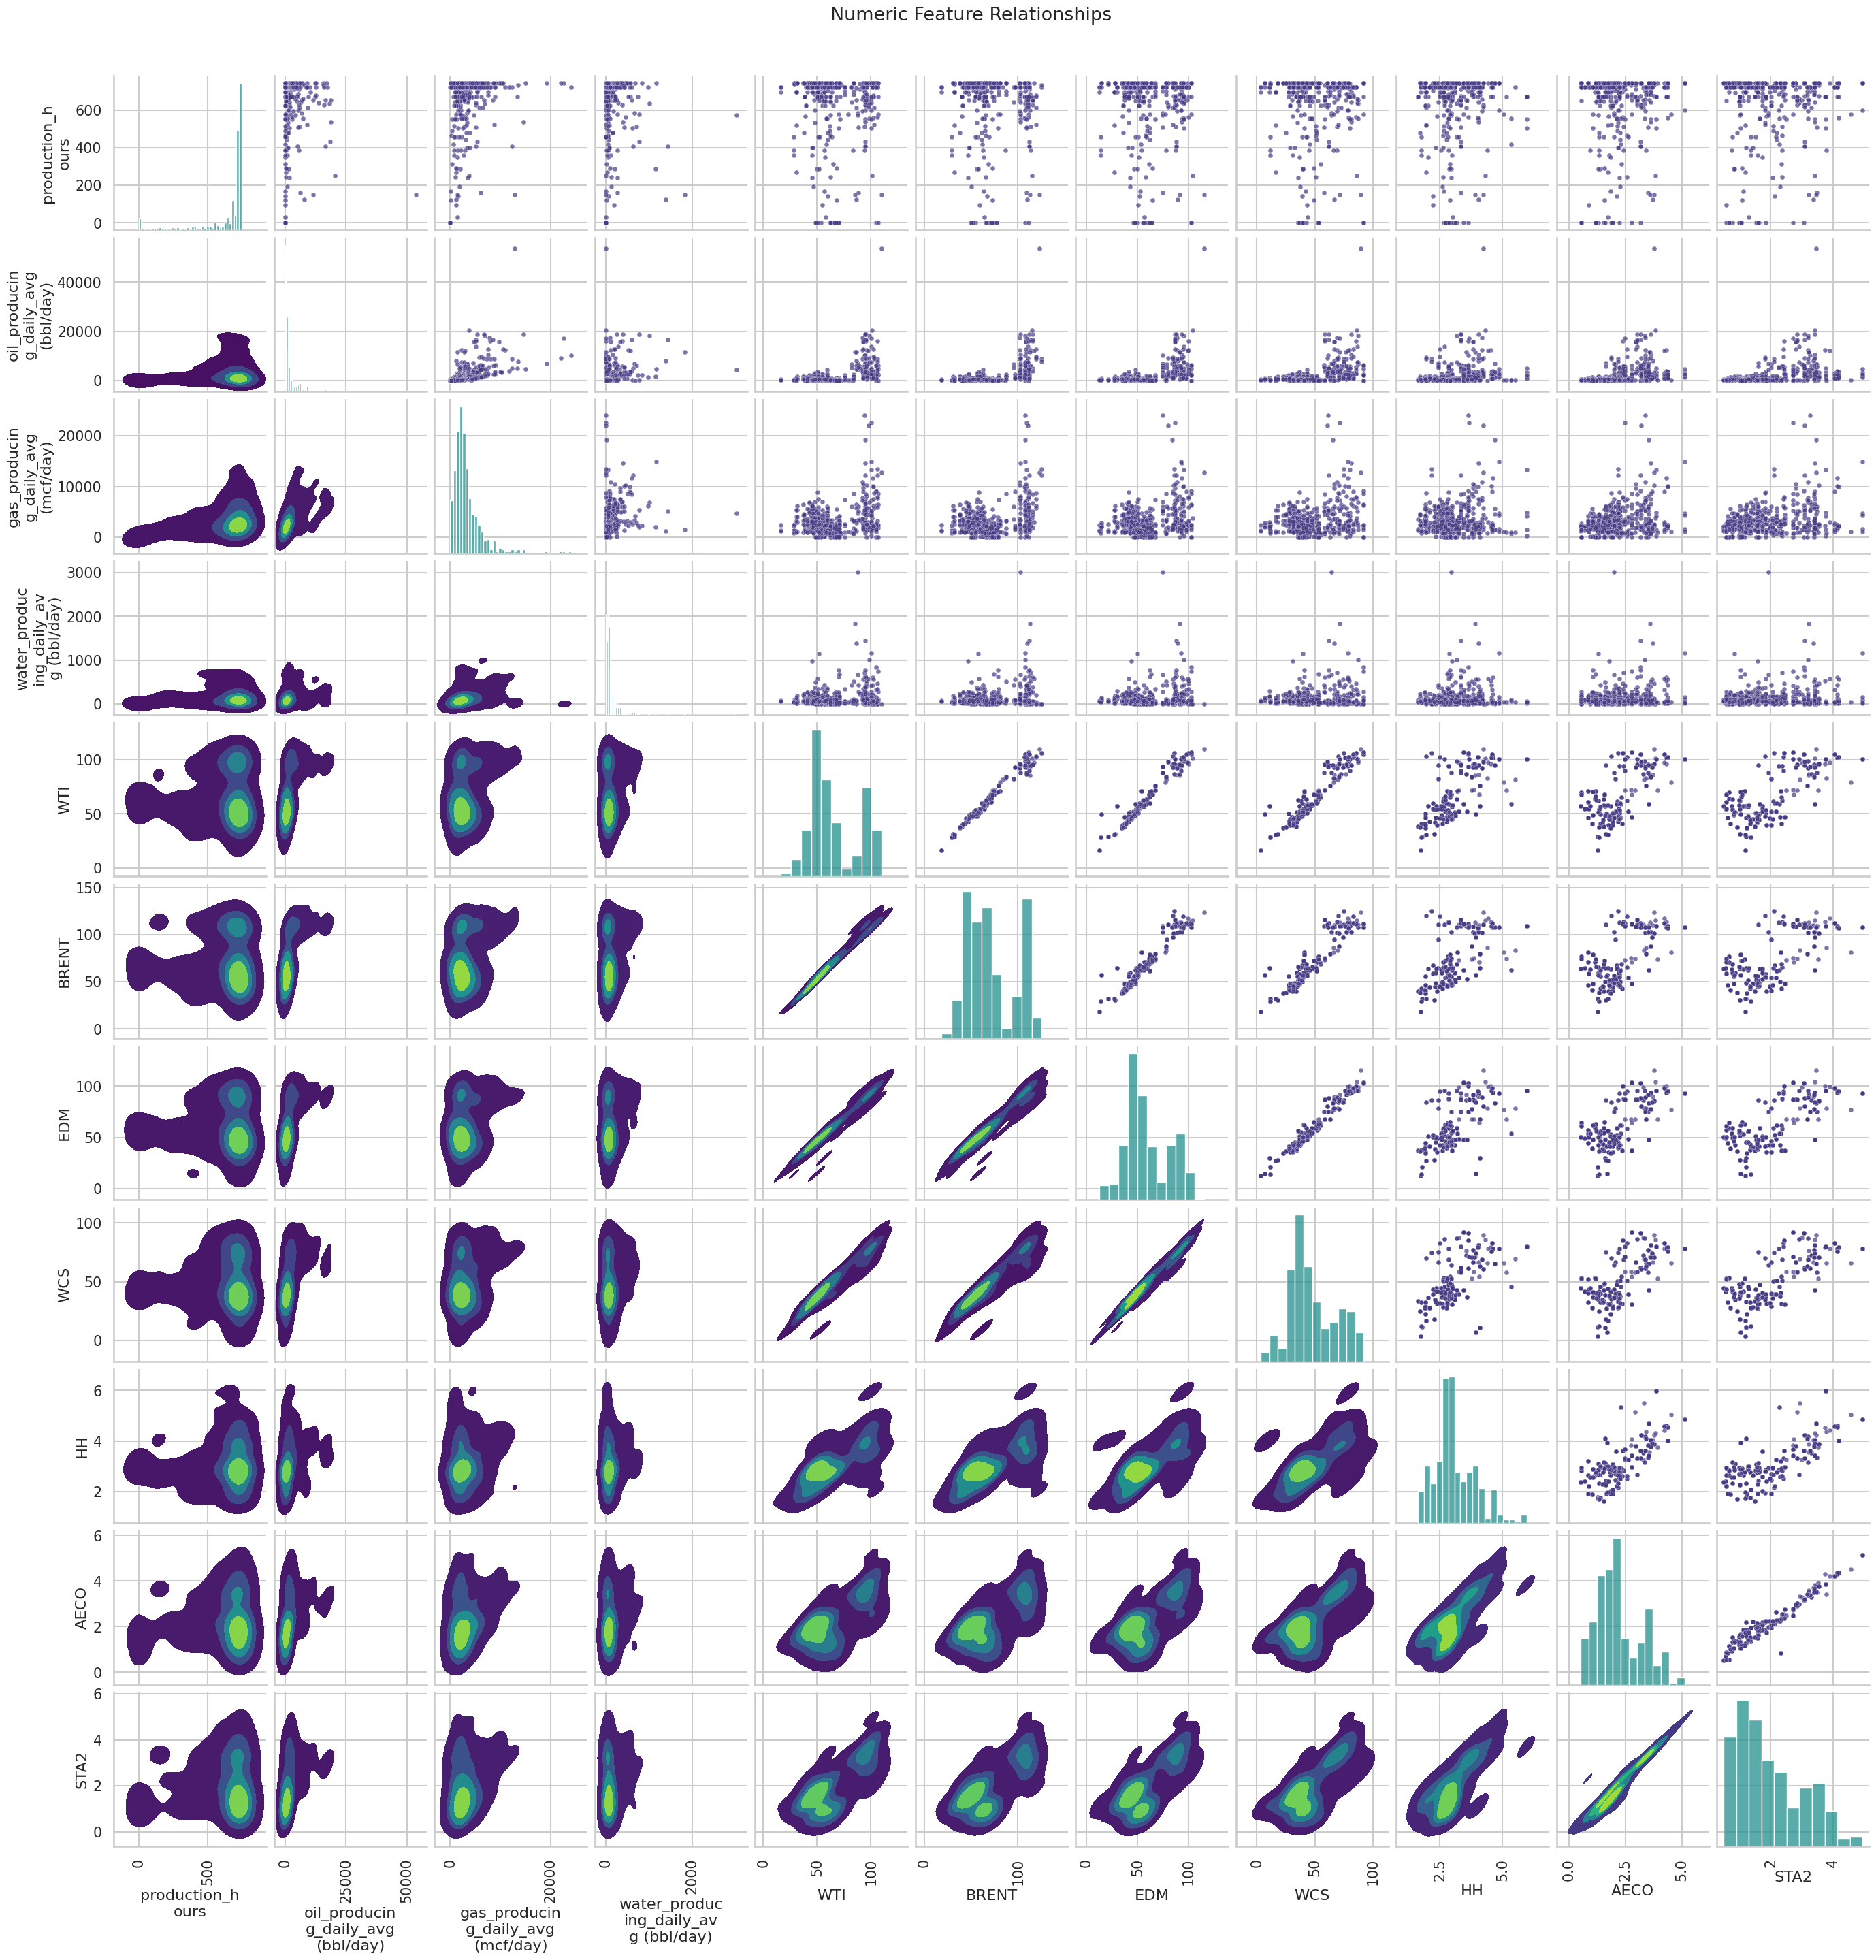

In [266]:
# Filter to only numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
pairgrid_df = df[numeric_cols].dropna()

# Set theme
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.9)
sns.set_palette('viridis')
viridis_colors = sns.color_palette('viridis_r', 5)
hist_color = viridis_colors[2]
scatter_color = viridis_colors[-1]
kde_cmap = sns.color_palette('viridis', as_cmap=True)

# Build the PairGrid with histograms on the diagonal, scatterplots above, and KDE contours below
pairgrid = sns.PairGrid(pairgrid_df, diag_sharey=False)
pairgrid.map_diag(sns.histplot, color=hist_color, edgecolor='white', linewidth=1.0)
pairgrid.map_upper(sns.scatterplot, color=scatter_color, s=25, alpha=0.7, edgecolor='white', linewidth=0.3)
pairgrid.map_lower(sns.kdeplot, fill=True, thresh=0.04, levels=5, cmap=kde_cmap, linewidths=0.8)

# Rotate and wrap long axis labels
for ax in pairgrid.axes.flatten():
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='y', labelrotation=0)
    ax.set_xlabel(fill(ax.get_xlabel(), 12))
    ax.set_ylabel(fill(ax.get_ylabel(), 12))

# Remove extra whitespace and add an overall title
plt.subplots_adjust(wspace=0.05, hspace=0.05)
pairgrid.fig.suptitle('Numeric Feature Relationships', y=1.02)

pairgrid

> - Obvious correlations are observed between the production volumes and production rates. This makes sense since they are just a transformation of each other (as described in the Feature Descriptions section).
> - Correlations also exist among the crude oil pricing columns (`WTI`, `BRENT`, `EDM`, `WCS`). These are not unusual since most crude oils are priced relative to WTI. Similarly correlations are also observed for the natural gas prices between `AECO` and `STA2`. This is expected since both commodites are traded into similar markets.
> - No other obvious correlations are observed among the other numeric columns.

#### Correlation Matrix
- The correlation matrix is a heatmap of pairwise correlations between production and pricing features, helping this analysis quickly spot which variables move together before selecting inputs for the LSTM

<Axes: title={'center': 'Numeric Feature Correlation Matrix'}>

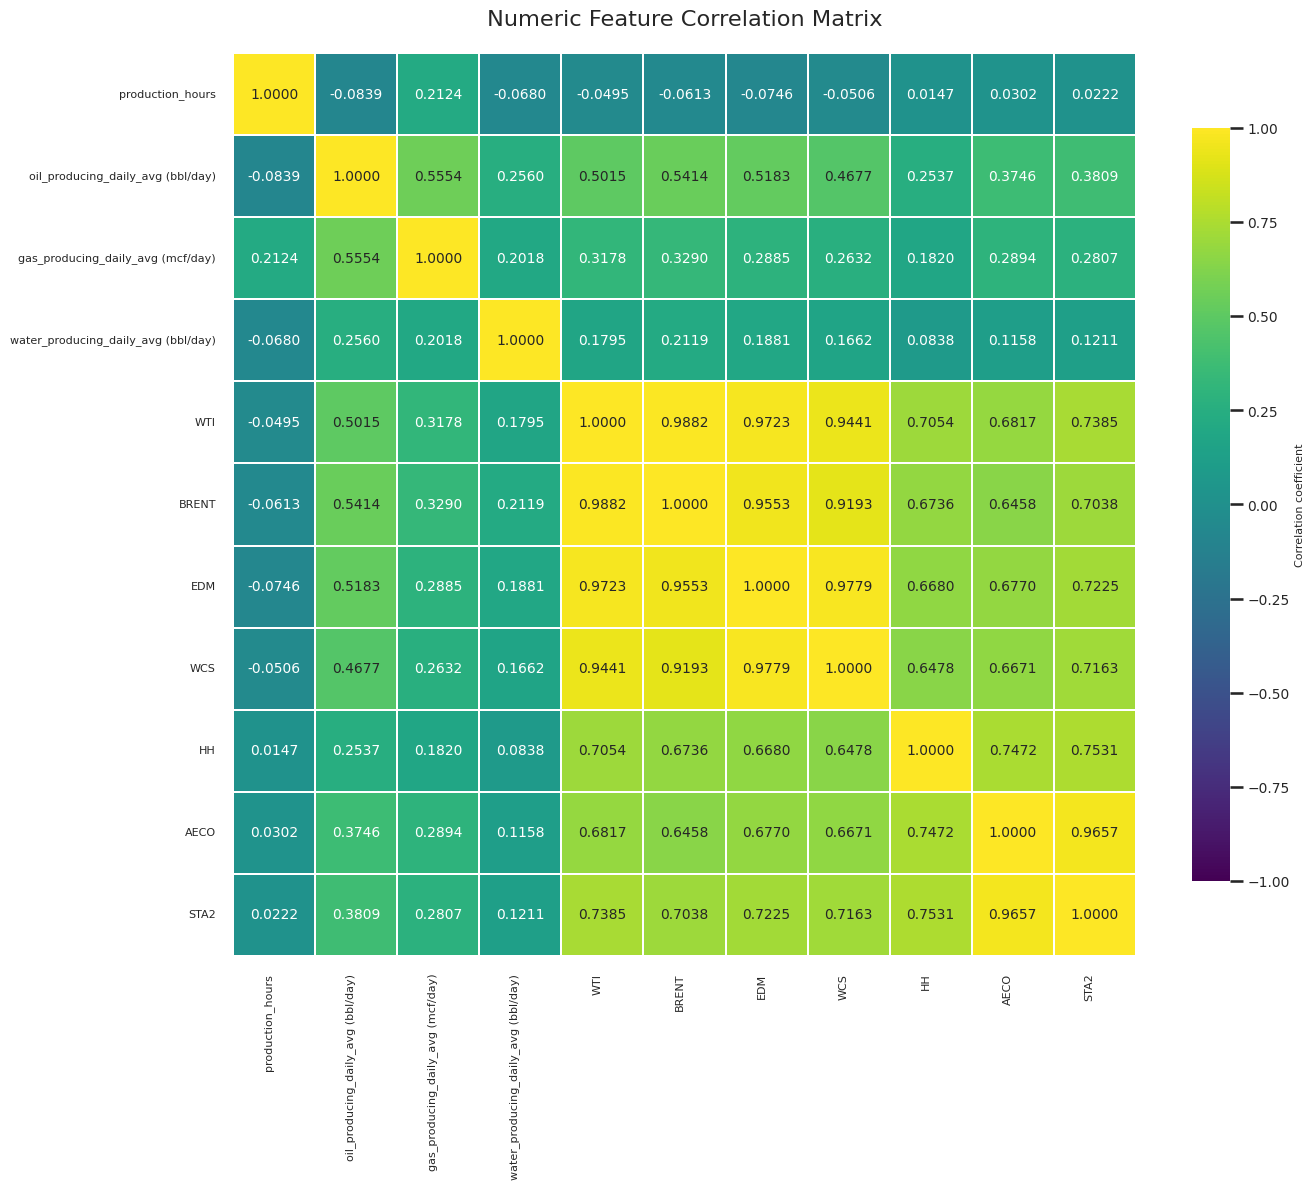

In [267]:
# Compute the correlation matrix across all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=0.9)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(
    corr_matrix,
    cmap='viridis',
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.4f',
    annot_kws={'size': 10},
    linewidths=0.3,
    cbar_kws={'label': 'Correlation coefficient', 'shrink': 0.8},
    square=True
)

# Resize the legend
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation coefficient', size=8)

# Realign axis labels
heatmap.set_title('Numeric Feature Correlation Matrix', pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=8)
plt.tight_layout()

heatmap

> Correlations that were visually observed in the pairplot are confirmed in the correlation heatmap.

#### Production Time Series Plots
- Oil and natural gas production rates typically exponentially decline over time so they are plotted on a semi-log plot over time.

In [268]:
# Create labels for plot
prod_rate_dict = {
    'production_hours':'Hours On Production (hrs)',
    'oil_producing_daily_avg (bbl/day)':'Oil Production (bbl/d)',
    'gas_producing_daily_avg (mcf/day)':'Gas Production (mcf/d)',
    'water_producing_daily_avg (bbl/day)':'Water Production (bbl/d)'
}

# Convert data into a dataframe for Altair plotting
prod_rate_chart_df = (
    df[['well_name', 'date'] + [k for k in prod_rate_dict.keys()]]
        .rename(prod_rate_dict, axis=1)
        .replace({0:np.nan})
        .melt(id_vars=['well_name', 'date'], value_vars=[v for v in prod_rate_dict.values()])
)

# Create plot of log-scaled time series for oil rate, gas rate, water rate, and hours on for each well
alt.Chart(prod_rate_chart_df).mark_line().encode(
    alt.X('date:T').title(None),
    alt.Y('value:Q').scale(type='log').title('Production Rate (bb/d or mcf/d)'),
    alt.Color('variable:N').scale(domain=[v for v in prod_rate_dict.values()], range=['grey', '#2ca02c', '#d62728', 'steelblue']),
    alt.Row('well_name:N').title(None),
    alt.Tooltip(['value:Q'])
).properties(
    height = 200,
    width = 800,
    title=alt.Title('Oil, Gas, and Water Production Rates Over Time', fontSize=20, anchor='start')
)

alt.Chart(...)

> The production time-series plots show that all five wells follow a broadly similar pattern: oil, gas, and water rates generally decline over time, with occasional operational disruptions reflected as sharp downward spikes. Oil production (green) and gas production (red) tend to track closely, while water production (blue) is more volatile and exhibits larger swings, especially during periods of facility downtime or well interventions. Although each well has its own operational signature, the overall trend across the dataset is a gradual reduction in output punctuated by short-term anomalies, making the forecasting problem well-suited to sequence-learning models that must capture both long-term decline and intermittent variability.

#### Oil Production Rate Moving Averages
- Visualizing the 12 month, 24, and 36 months oil production rate moving averages.

In [269]:
# Create dataset for moving-average smoothing
ma_chart_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].replace({0:np.nan})

# Define the moving-average windows
window_specs = [
    (12, '12-month MA'),
    (24, '24-month MA'),
    (36, '36-month MA'),
]

# Define moving-average line colors
window_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
color_scale = alt.Scale(
    domain=[label for _, label in window_specs],
    range=window_colors
)

# Build base MA chart
base = alt.Chart(ma_chart_df).encode(
    alt.X('date:T').title('Date')
)

# Plot oil production line chart
raw_line = base.mark_line(color='green', opacity=0.2, size=5).encode(
    alt.Y('oil_producing_daily_avg (bbl/day):Q').title('Oil producing daily avg (bbl/day)').scale(type='log')
)

# Create each moving-average line charts
ma_layers = []
for window, label in window_specs:
    ma_layer = base.transform_window(
        rolling_mean='mean(oil_producing_daily_avg (bbl/day))',
        frame=[-(window - 1), 0],
        groupby=['well_name'],
        sort=[alt.SortField('date')]
    ).transform_calculate(
        window_label=f"'{label}'"
    ).mark_line(size=3, opacity=0.75, strokeDash=[10,4]).encode(
        y='rolling_mean:Q',
        color=alt.Color('window_label:N').scale(color_scale).title('Moving Average')
    ).properties(
        height = 200,
        width = 800,
    )
    ma_layers.append(ma_layer)

# Layer the raw_line and ma_layer charts, facet by well
layered_ma_chart = alt.layer(*ma_layers, raw_line).facet(
    row=alt.Row('well_name:N', title='Well')
).properties(
    title=alt.Title('12, 24, and 36 Month Moving Averages of the Oil Production Rate (bbl/d)', fontSize=20, anchor='start')
)

layered_ma_chart

alt.FacetChart(...)

> The 12, 24, and 36-month moving average curves show that every well’s oil production rate follows a steady downward slope, with the longer windows smoothing out the month-to-month volatility. Large negative spikes mark occasional shut-ins or outages, but the multi-year trend remains a gradual decline across all wells.

#### Oil Production Percent Change
- The month-to-month percent change chart tracks how each well’s production jumps or drops from one month to the next, helping the analysis identify volatility bursts or shut-in events to account for when modeling the LSTM

In [270]:
# Compute month-over-month percent change in oil production for each well
pct_change_df = df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']].copy()
pct_change_df = pct_change_df.sort_values(['well_name', 'date'])
pct_change_df['pct_change'] = pct_change_df.groupby('well_name')['oil_producing_daily_avg (bbl/day)'].pct_change() * 100
pct_change_df = pct_change_df.dropna(subset=['pct_change'])
pct_change_df['pct_change'] = pct_change_df['pct_change'].clip(-100, 100)

# Define positive/negative color scale
color_scale = alt.Scale(domain=['Increase', 'Decrease'], range=['#2ca02c', '#d62728'])

# Plot a the percent change chart
pct_change_chart = alt.Chart(pct_change_df).mark_bar().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('pct_change:Q', title='Month-to-month % change', scale=alt.Scale(domain=[-100, 100])),
    color=alt.Color(
        'change_direction:N',
        scale=color_scale,
        legend=alt.Legend(title='Direction')
    ),
    tooltip=[
        alt.Tooltip('well_name:N', title='Well'),
        alt.Tooltip('date:T', title='Date'),
        alt.Tooltip('pct_change:Q', title='% change', format='.2f')
    ]
).transform_calculate(
    change_direction="datum.pct_change >= 0 ? 'Increase' : 'Decrease'"
).properties(
    height=200,
    width=800
).facet(
    row=alt.Row('well_name:N', title='Well')
).resolve_scale(
    y='shared'
).properties(
    title=alt.Title('Month-to-Month Percent Change of the Oil Production Rate', fontSize=20, anchor='start', subtitle='(capped at +/-100%)')
)

pct_change_chart

alt.FacetChart(...)

> The month-to-month percent change plots show that all five wells experience far more negative changes than positive ones, reflecting the natural decline behaviour of oil production over time. Periodic positive spikes do occur, but they are comparatively infrequent and smaller in magnitude, suggesting short-term operational or reservoir events that temporarily boosted production. These upward excursions merit further investigation, as they may indicate workovers, facility optimizations, or reservoir pressure responses that could inform future production-enhancement strategies.

#### Seasonal Decomposition Plots
- Seasonal decomposition charts break each time series into trend, seasonal, and residual components, revealing long-term decline, recurring seasonal patterns, and irregular shocks separately.
- In this analysis they help determine whether seasonal patterns or residual noise should be modeled explicitly or if the LSTM can focus mostly on the trend and notable anomalies.

In [271]:
# Collect seasonal decomposition components for every well
decomposition_records = []
value_col = 'oil_producing_daily_avg (bbl/day)'

for well_name, group in df[['well_name', 'date', value_col]].dropna(subset=[value_col]).sort_values('date').groupby('well_name'):
    well_series = group.set_index('date')[value_col]
    monthly_series = well_series.resample('MS').mean().interpolate(limit_direction='both')

    if len(monthly_series.dropna()) < 24:
        continue

    decomposition = seasonal_decompose(
        monthly_series,
        model='additive',
        period=12,
        extrapolate_trend='freq'
    )

    component_map = {
        'Observed': decomposition.observed,
        'Trend': decomposition.trend,
        'Seasonal': decomposition.seasonal,
        'Residual': decomposition.resid
    }

    for component_name, component_values in component_map.items():
        component_df = component_values.reset_index()
        component_df.columns = ['date', 'value']
        component_df['component'] = component_name
        component_df['well_name'] = well_name
        decomposition_records.append(component_df)

# Combine component data and drop rows created by leading/trailing NaNs
seasonal_decomposition_df = pd.concat(decomposition_records, ignore_index=True)
seasonal_decomposition_df = seasonal_decomposition_df.dropna(subset=['value'])
component_order = ['Observed', 'Trend', 'Seasonal', 'Residual']

# Plot the observed, trend, seasonal, and residual series for each well in a faceted grid
seasonal_decomposition_chart = alt.Chart(seasonal_decomposition_df).mark_line(color='#2ca02c').encode(
    x=alt.X('date:T').title(None),
    y=alt.Y('value:Q').title(None),
    column=alt.Row('component:N', sort=component_order, title=None),
    row=alt.Column('well_name:N', title=None),
    color=alt.Color('well_name:N', title='Well', scale=alt.Scale(scheme='viridis'))
).resolve_scale(
    y='independent'
).properties(
    height=150,
    width=175,
    title=alt.Title('Seasonal Decomposition of the Oil Production Rate', fontSize=20, anchor='start')
)

seasonal_decomposition_chart

alt.Chart(...)

> The seasonal decomposition charts show a steep decline in each well’s long-term trend followed by a flat tail, while the seasonal component oscillates annually with consistent amplitude—**clear evidence of recurring 12-month seasonality**. Residuals remain relatively small after the initial drop, suggesting most structure is captured by the trend and seasonal terms. LSTM's inherently handle seasonality, but if model fits are insufficient then we could consider applying temporal differencing to account for these cyclical effects.

#### Autocorrelation Plot
- The autocorrelation plot shows how each well’s production correlates with its past values at different lags, helping this analysis gauge how far back the LSTM needs to look to capture meaningful temporal dependencies.

In [394]:
# Group by well
well_groups = (
    df[['well_name', 'date', 'oil_producing_daily_avg (bbl/day)']]
    .dropna(subset=['oil_producing_daily_avg (bbl/day)'])
    .sort_values('date')
    .groupby('well_name')
)

# Define horizon to analyze autocorrelation over
horizon = 36

# Create ACF datasets
acf_records = []
for well_name, group in well_groups:
    monthly_series = group.set_index('date')[value_col].resample('MS').mean().interpolate(limit_direction='both')
    acf_values = acf(monthly_series, nlags=horizon, fft=False, missing='drop')
    for lag in range(1, horizon + 1):
        acf_records.append({
            'well_name':     well_name,
            'lag':           lag,
            'acf':           acf_values[lag],
            'horizon_label': f"{horizon}-month"
        })

# Plot ACF chart
acf_df = pd.DataFrame(acf_records)
acf_chart = alt.Chart(acf_df).mark_bar().encode(
    x=alt.X('lag:O', title='Lag (months)', axis=alt.Axis(values=[6, 12, 18, 24, 30, 36])),
    y=alt.Y('acf:Q', title='Autocorrelation', scale=alt.Scale(domain=[-1, 1])),
    column=alt.Column('well_name:N', title=None),
    row=alt.Row('horizon_label:N', sort=[f"36-month"], title='Horizon'),
    color=alt.condition(alt.datum.acf >= 0, alt.value('#1f77b4'), alt.value('#d62728'))
).resolve_scale(
    y='shared'
).properties(
    height=200,
    width=160,
    title=alt.Title('36 month Autocorrelation of the Oil Production Rate', fontSize=20, anchor='start')
)

acf_chart

alt.Chart(...)

> Autocorrelation stays strongly positive through roughly the first 12–18 months for every well, confirming that recent production levels heavily influence the next year’s output. Beyond about 24 months the correlations decay to near zero or slightly negative, suggesting the model can safely prioritize shorter lookback windows without losing much signal. With this knowledge **I'll consider testing look back windows of 12, 24, and 36 months for the LSTM models**.

## DATA CLEANING & PREPROCESSING

#### Adding Columns Required for Modeling
- A `months_on` column is added that calculates the number of months the well has been on production since its first month of production.
- A set of dummy variable columns are created that define general states of the oil and gas industry over time.

In [273]:
# Add a months_on column which is the number of months a well has produced since it was first put on production
df['months_on'] = df.groupby('well_name')['date'].transform(lambda s: s.rank(method='first').astype(int))

In [274]:
# Add columns that identify key events affecting the oil and gas industry
indicator_windows = {
    'middle_instability_tightening_supply': [('2009-01-01', '2014-08-01')],
    'opec_oversupply_during_downturn':      [('2014-09-01', '2016-02-01')],
    'opec_undersupply_during_recovery':     [('2016-03-01', '2020-02-01')],
    'covid':                                [('2020-03-01', '2022-06-01')],
    'ukraine_war':                          [('2022-02-01', '2025-11-01')]
}

# Create date index
min_prod_date = df['date'].min().to_period('M').to_timestamp()
date_index = pd.date_range(start=min_prod_date, end='2025-11-01', freq='MS')

# Create & populate dummy variables
dummy_df = pd.DataFrame({'date': date_index})
for indicator, windows in indicator_windows.items():
    dummy_df[indicator] = 0
    for start, end in windows:
        start_ts = pd.Timestamp(start)
        end_ts = pd.Timestamp(end)
        mask = (dummy_df['date'] >= start_ts) & (dummy_df['date'] <= end_ts)
        dummy_df.loc[mask, indicator] = 1

# Merge dummy_df with the dataset
df = df.merge(dummy_df, how='left')

# Display the updated dataset
df

well_name       date  production_hours  oil_producing_daily_avg (bbl/day)  \
0      well_1 2013-01-01               408                       16453.411760   
1      well_1 2013-02-01               629                       16161.119240   
2      well_1 2013-03-01               743                       15883.833110   
3      well_1 2013-04-01               720                       12569.133330   
4      well_1 2013-05-01               696                       10410.724140   
..        ...        ...               ...                                ...   
485    well_5 2018-05-01               744                         253.612903   
486    well_5 2018-06-01               720                         119.500000   
487    well_5 2018-07-01               744                          26.387097   
488    well_5 2018-08-01               120                         100.600000   
489    well_5 2018-09-01               720                          54.500000   

     gas_producing_daily_avg (mcf/day)  water_producing_daily_avg (bbl/day)  \
0                          5068.647059                          1439.235294   
1                          5106.848967                           388.769475   
2                          9696.032301                           335.224764   
3                         10888.633330                           119.500000   
4                          7586.517241                           169.172414   
..                                 ...                                  ...   
485                        1446.741935                            48.709677   
486                          35.300000                           104.833333   
487                          45.580645                            24.354839   
488                          70.600000                            25.200000   
489                         188.333333                           264.166667   

       WTI   BRENT    EDM    WCS    HH  AECO  STA2  months_on  \
0    94.83  112.16  88.10  62.09  3.33  3.18  3.08          1   
1    95.32  116.02  87.12  58.36  3.33  3.03  2.84          2   
2    92.96  108.56  86.95  66.71  3.81  2.96  2.79          3   
3    92.07  102.25  89.04  68.79  4.17  3.39  3.18          4   
4    94.80  102.56  93.55  81.07  4.04  3.63  3.42          5   
..     ...     ...    ...    ...   ...   ...   ...        ...   
485  69.98   76.98  64.06  53.40  2.83  0.56  0.66         65   
486  67.87   74.41  61.23  52.79  2.94  0.56  0.57         66   
487  70.98   74.25  63.18  52.85  2.79  1.18  1.16         67   
488  68.06   72.53  64.93  48.91  2.91  1.58  1.08         68   
489  70.23   78.89  61.94  40.84  2.90  1.05  1.04         69   

     middle_instability_tightening_supply  opec_oversupply_during_downturn  \
0                                       1                                0   
1                                       1                                0   
2                                       1                                0   
3                                       1                                0   
4                                       1                                0   
..                                    ...                              ...   
485                                     0                                0   
486                                     0                                0   
487                                     0                                0   
488                                     0                                0   
489                                     0                                0   

     opec_undersupply_during_recovery  covid  ukraine_war  
0                                   0      0            0  
1                                   0      0            0  
2                                   0      0            0  
3                                   0      0            0  
4                                   0      0            0  
..  

#### Scale Data
- Models are trained using the concatenation of all the well's `X_train` and `y_train` datasets, and then individually predicted and tested using each wells `X_test` and `y_test` datasets.
- Because of this I scale the entire dataset's numeric features to a mean of 0 and standard deviation of 1 to improve generality of the LSTM models.
- Numeric features that are scaled are:
  - `production_hours`
  - `oil_producing_daily_avg (bbl/day)`
  - `gas_producing_daily_avg (mcf/day)`
  - `water_producing_daily_avg (bbl/day)`
  - `WTI`
  - `BRENT`
  - `EDM`
  - `WCS`
  - `HH`
  - `AECO`
  - `STA2`
  - `months_on`

In [275]:
# Fit the StandardScaler so X features can be scaled later
scaler = StandardScaler()
scaler.fit(df.iloc[:, 2:14])

StandardScaler()

#### Train-Test Split
- LSTM models expect a 3-dimensional dataframe as input with a shape of: ($\textit{samples}$, $\textit{look back}$, $\textit{number of features}$).
  - Where:
    - $\textit{samples}$ = are the number of unique time slices generated from the set of features $X$
    - $\textit{look back}$ = is the length of each sample (measured in months)
    - $\textit{number of features}$ = are the number of feature variables in the input matrix $X$
- The `create_dataset` function below creates the 3-dimensional LSTM inputs for a given input dataset
  - The target values $y$ are the `oil_producing_daily_avg (bbl/day)` values taken at time $t+1$
  - The feature matrix $X$ contains 17 features:
    - `production_hours`
    - `oil_producing_daily_avg (bbl/day)`
    - `gas_producing_daily_avg (mcf/day)`
    - `water_producing_daily_avg (bbl/day)`
    - `WTI`
    - `BRENT`
    - `EDM`
    - `WCS`
    - `HH`
    - `AECO`
    - `STA2`
    - `months_on`
    - `middle_instability_tightening_supply`
    - `opec_oversupply_during_downturn`
    - `opec_undersupply_during_recovery`
    - `covid`
    - `ukraine_war`
- $X$ and $y$ are split into training and testing sets, where:
  - the first 80% of the time series is used as the training set, and 
  - the last 20% of the time series is used as the testing set
- Scaling is applied where:
  - The $X$ numeric values are scaled using the standard scaler mentioned above
  - $y$ is log transformed (with a scaling factor of 1e-6 added to avoid errors when $y=0$)
- The `X_train` and `y_train` sets for each well are stacked into one so the model can be trained on one complete training dataset

In [276]:
# Function to scale and split a dataset into X_train, X_test, y_train, y_test
def create_train_test_split(dataset, look_back, scaler):
    # Drop date and well_name columns
    dataset = dataset[[col for col in dataset.columns if col not in ['date', 'well_name']]]

    # Split into X & y
    X = dataset.iloc[0:(len(dataset)-1), :].to_numpy()
    y = dataset.iloc[1:, 1]

    # Scale the numeric features in X
    X[:,:12] = scaler.transform(X[:,:12])

    # Log transform y
    y_log = np.log(y + SCALING_FACTOR).to_numpy()

    # Split into train & test sets
    train_idx = int(len(X) * SPLIT_RATIO)
    X_train, X_test, y_train, y_test = [], [], [], []

    # Create X_train & y_train datasets
    for i in range(train_idx - look_back + 1):
        X_train_sample = X[i:(i + look_back), :]
        X_train.append(X_train_sample)
        y_train.append(y_log[i + look_back - 1])
    X_train = np.array(X_train) # X_train.shape = (train_idx - look_back + 1, look_back, n_features)
    y_train = np.array(y_train) # y_train.shape = (train_idx - look_back + 1, )

    # Create X_test & y_test datasets
    for i in range(train_idx - look_back + 1, len(X) - look_back + 1):
        X_test_sample = X[i:(i+look_back), :]
        X_test.append(X_test_sample)
        y_test.append(y_log[i + look_back - 1])
    X_test = np.array(X_test) # X_test.shape = (len(X) - train_idx, look_back, n_features)
    y_test = np.array(y_test) # y_test.shape = (len(y) - train_idx, )

    return X_train, X_test, y_train, y_test

# Function to loop over look_back windows and well_names to create a dictionary of train-test datasets that will be used for model training
def create_train_test_dict(df, scaler):
    train_test_dict = {}
    for look_back in [12, 24, 36]:
        for well_name in df['well_name'].unique():

            # Ensure nested levels exist
            if well_name not in train_test_dict:
                train_test_dict[well_name] = {}
            if look_back not in train_test_dict[well_name]:
                train_test_dict[well_name][look_back] = {}

            # Extract dataset
            dataset = df[df['well_name'] == well_name]
            X_train, X_test, y_train, y_test = create_train_test_split(dataset, look_back, scaler)

            # Create entires
            train_test_dict[well_name][look_back] = {
                'X_train': X_train,
                'X_test':  X_test,
                'y_train': y_train,
                'y_test':  y_test
            }
            
    return train_test_dict

# Generate datasets dictionary
train_test_dict = create_train_test_dict(df, scaler)

In [277]:
# Dataset shapes from train_test_dict for X_train and y_train for lookbacks = 12, 24, and 36 months
print('X_train has shape (samples, look_back, n_features)\ny_train has shape (samples, )')
for look_back in [12, 24, 36]:
    _x_train = np.concatenate([train_test_dict[well_name][look_back]['X_train'] for well_name in df['well_name'].unique()], axis=0)
    _y_train = np.concatenate([train_test_dict[well_name][look_back]['y_train'] for well_name in df['well_name'].unique()], axis=0)
    print(f'\nCombined training dataset shapes for look_back = {look_back}:\n-> X_train : {_x_train.shape}\n-> y_train : {_y_train.shape}')

X_train has shape (samples, look_back, n_features)
y_train has shape (samples, )

Combined training dataset shapes for look_back = 12:
-> X_train : (332, 12, 17)
-> y_train : (332,)

Combined training dataset shapes for look_back = 24:
-> X_train : (272, 24, 17)
-> y_train : (272,)

Combined training dataset shapes for look_back = 36:
-> X_train : (212, 36, 17)
-> y_train : (212,)


## LSTM MODELING
LSTM models are a type of recurrent neural network designed to learn patterns in sequences, especially when important information appears far back in time. They use internal memory cells to decide what to keep, update, or forget, which helps them capture long-term trends more effectively than standard RNNs. This makes them well suited for forecasting tasks like oil production, where past behavior strongly influences future values.

#### Define LSTM Models
- In this analysis I evaluate four LSTM-based architectures for forecasting oil production.
- The first is the Vanilla LSTM, which I use as my Base LSTM and treat as the reference point for performance comparison.
- The remaining models — the Bidirectional LSTM, Stacked LSTM, and CNN-LSTM — are tested to determine whether more advanced sequence-modeling approaches provide improvements over the base configuration.

In [278]:
# Define LSTM model instances
def create_LSTM_model(model_type, n_nodes, look_back, learning_rate, dropout, n_features):
    strategy = tf.distribute.MirroredStrategy() # Utilize GPUs
    with strategy.scope():
        model = Sequential()
        if model_type == 'base': # Base LSTM
            model.add(LSTM(n_nodes, input_shape=(look_back, n_features)))
        if model_type == 'bidirectional': # Bidirectional LSTM
            model.add(Bidirectional(LSTM(n_nodes), input_shape=(look_back, n_features)))
        if model_type == 'stacked': # Stacked LSTM
            model.add(LSTM(n_nodes * 2, return_sequences=True, input_shape=(look_back, n_features)))
            model.add(LSTM(n_nodes))
        if model_type == 'cnn': # CNN-LSTM
            model.add(Conv1D(filters=32, kernel_size=3, padding='causal', input_shape=(look_back, n_features)))
            model.add(MaxPooling1D(pool_size=2))
            model.add(LSTM(n_nodes))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    return model

#### Fit Base LSTM Model
- The base LSTM is a standard recurrent model that learns how past production values influence future rates.
- It processes the sequence step by step, capturing the general decline and short-term patterns in the data.

In [324]:
# Fit base LSTM
def fit_lstm(model):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE) # Add early stopping to prevent overfitting
    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=(1-SPLIT_RATIO),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    return history

# Create loss plot
def plot_loss(history, model_type):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_type} Model Train Loss vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    ax1.set_ylabel('Oil Production Rate (bbl/d)', fontsize=10)
    ax1.set_xlabel('Months', fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=10)

# Define base LSTM model inputs
model_type = 'base'
look_back = 12
n_nodes = 4
learning_rate = 0.001
dropout = 0.1

# Generate X_train and y_train datasets for the given n_nodes, look_back and learning_rate
X_train = np.concatenate([train_test_dict[well_name][look_back]['X_train'] for well_name in train_test_dict.keys()], axis=0)
y_train = np.concatenate([train_test_dict[well_name][look_back]['y_train'] for well_name in train_test_dict.keys()], axis=0)

# Generate the base model instance and display model summary
model = create_LSTM_model(model_type, n_nodes, look_back, learning_rate, dropout, X_train.shape[2])
model.summary()

# Fit the base model LSTM and display the loss plot
history = fit_lstm(model)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357 (1.39 KB)

 Trainable params: 357 (1.39 KB)

 Non-trainable params: 0 (0.00 B)

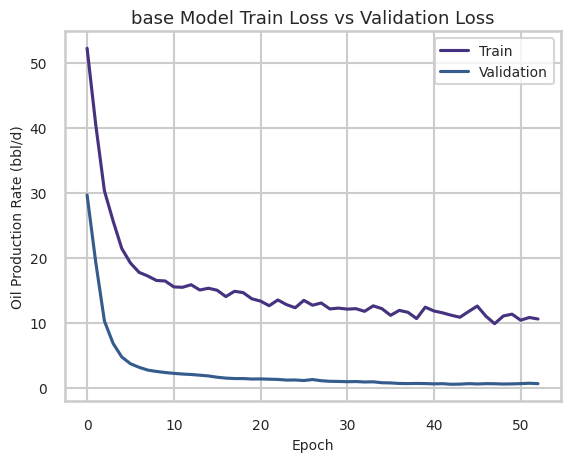

In [325]:
# Create loss plot
def plot_loss(history, model_type):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_type} Model Train Loss vs Validation Loss', fontsize=13)
    plt.ylabel('Loss', fontsize=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.legend(['Train', 'Validation'], loc='upper right', fontsize=10)
    plt.ylabel('Oil Production Rate (bbl/d)', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
plot_loss(history, model_type)

> The Base LSTM shows a rapid reduction in both training and validation loss during the early epochs, indicating that the model quickly learns the dominant production patterns. After this initial phase, both curves level off smoothly with no divergence, suggesting stable training and no clear signs of overfitting.

#### Well 1 Base LSTM Prediction


Root Mean Squared Error Scores (well_1)

Train RMSE: 700.7
Test RMSE: 528.2


Actual vs Predicted Plots (well_1)



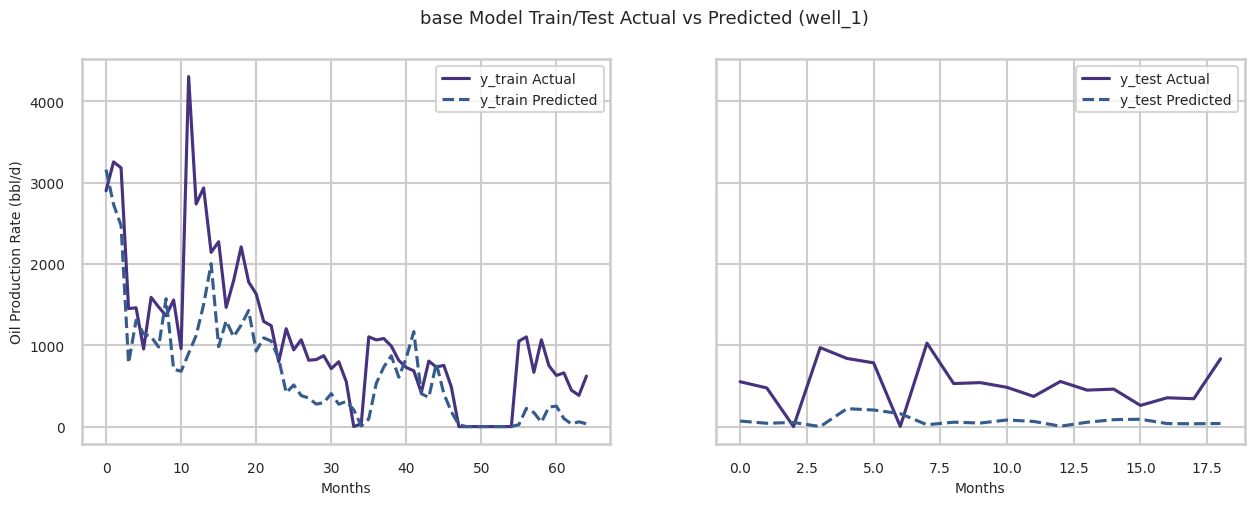

In [331]:
# Function to predict oil production from train-test datasets
def predict_oil_production(model_type, train_test_dict, well_name, look_back, history):
    X_train = train_test_dict[well_name][look_back]['X_train']
    y_train = train_test_dict[well_name][look_back]['y_train']
    X_test = train_test_dict[well_name][look_back]['X_test']
    y_test = train_test_dict[well_name][look_back]['y_test']

    # Make train-test predictions
    trainPredict = history.model.predict(X_train, verbose=0)
    testPredict = history.model.predict(X_test, verbose=0)

    # Unscale target variables and predictions
    y_train = np.exp(y_train) - SCALING_FACTOR
    trainPredict = np.exp(trainPredict) - SCALING_FACTOR
    y_test = np.exp(y_test) - SCALING_FACTOR
    testPredict = np.exp(testPredict) - SCALING_FACTOR

    # Calculate train-test RMSE
    print('\n============================================================================')
    print(f'Root Mean Squared Error Scores ({well_name})')
    print('============================================================================\n')   
    train_rmse = np.sqrt(mean_squared_error(y_train, trainPredict))
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    print(f'Train RMSE: {train_rmse:,.1f}')
    print(f'Test RMSE: {test_rmse:,.1f}\n')

    # Actual vs predicted train-test line charts
    print('\n============================================================================')
    print(f'Actual vs Predicted Plots ({well_name})')
    print('============================================================================\n')   
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5), sharey=True)

    ax1.plot(y_train, label='y_train Actual')
    ax1.plot(trainPredict, label='y_train Predicted', linestyle='dashed')
    ax1.legend(fontsize=10)
    ax1.set_ylabel('Oil Production Rate (bbl/d)', fontsize=10)
    ax1.set_xlabel('Months', fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    ax2.plot(y_test, label='y_test Actual')
    ax2.plot(testPredict, label='y_test Predicted', linestyle='dashed')
    ax2.legend(fontsize=10)
    ax2.set_xlabel('Months', fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    fig.suptitle(f'{model_type} Model Train/Test Actual vs Predicted ({well_name})', fontsize=13)

# Fit LSTM model and predict for well_1
predict_oil_production('base', train_test_dict, 'well_1', look_back, history)

#### Well 2 Base LSTM Prediction


Root Mean Squared Error Scores (well_2)

Train RMSE: 718.8
Test RMSE: 139.7


Actual vs Predicted Plots (well_2)



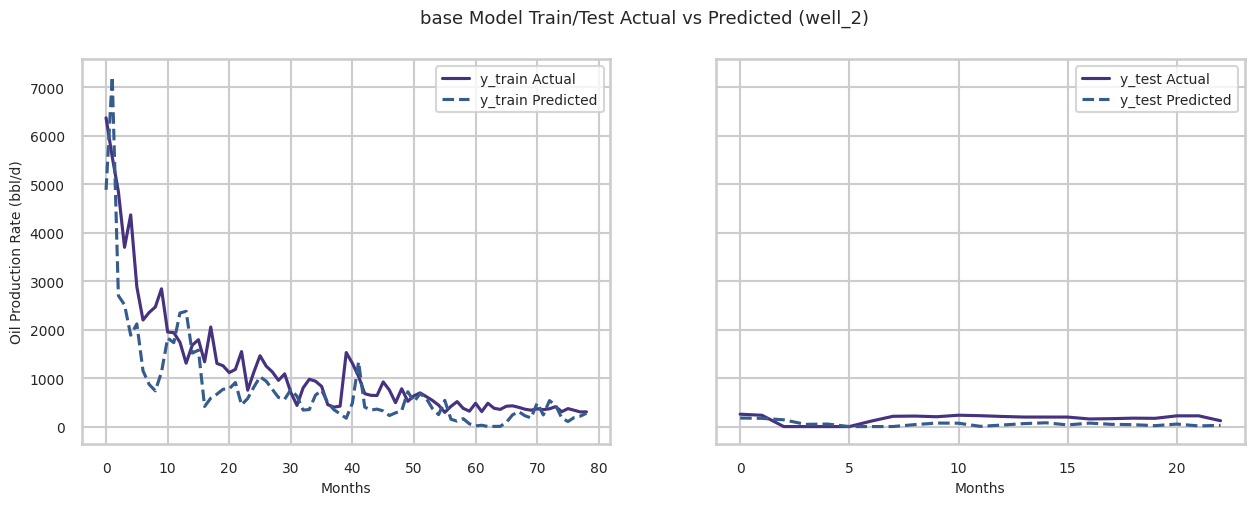

In [333]:
# Fit LSTM model and predict for well_2
predict_oil_production('base', train_test_dict, 'well_2', look_back, history)

#### Well 3 Base LSTM Prediction


Root Mean Squared Error Scores (well_3)

Train RMSE: 1,138.0
Test RMSE: 343.5


Actual vs Predicted Plots (well_3)



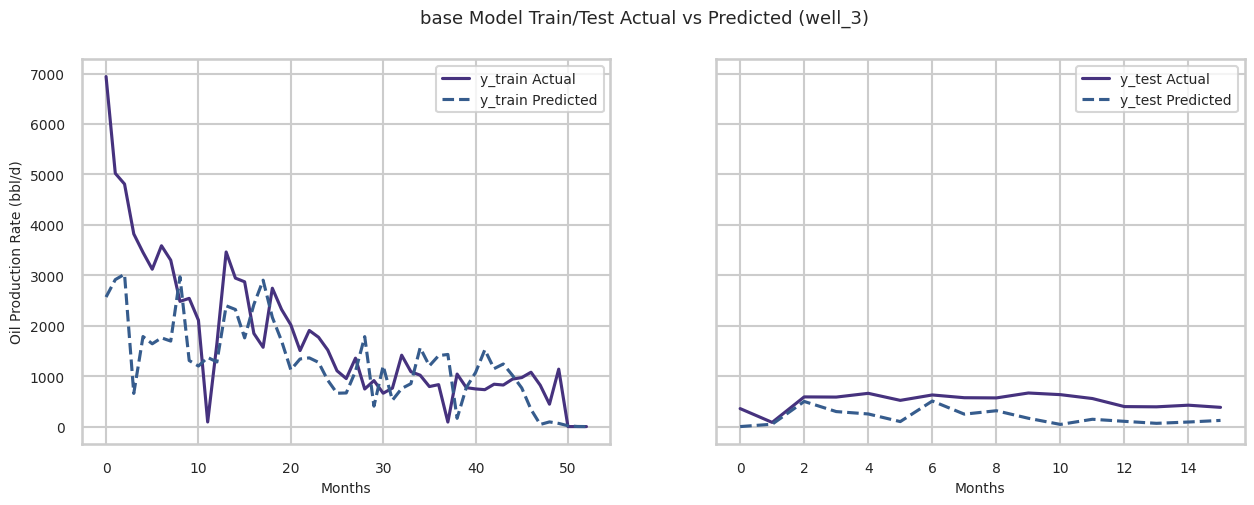

In [334]:
# Fit LSTM model and predict for well_3
predict_oil_production('base', train_test_dict, 'well_3', look_back, history)

#### Well 4 Base LSTM Prediction


Root Mean Squared Error Scores (well_4)

Train RMSE: 1,079.9
Test RMSE: 141.3


Actual vs Predicted Plots (well_4)



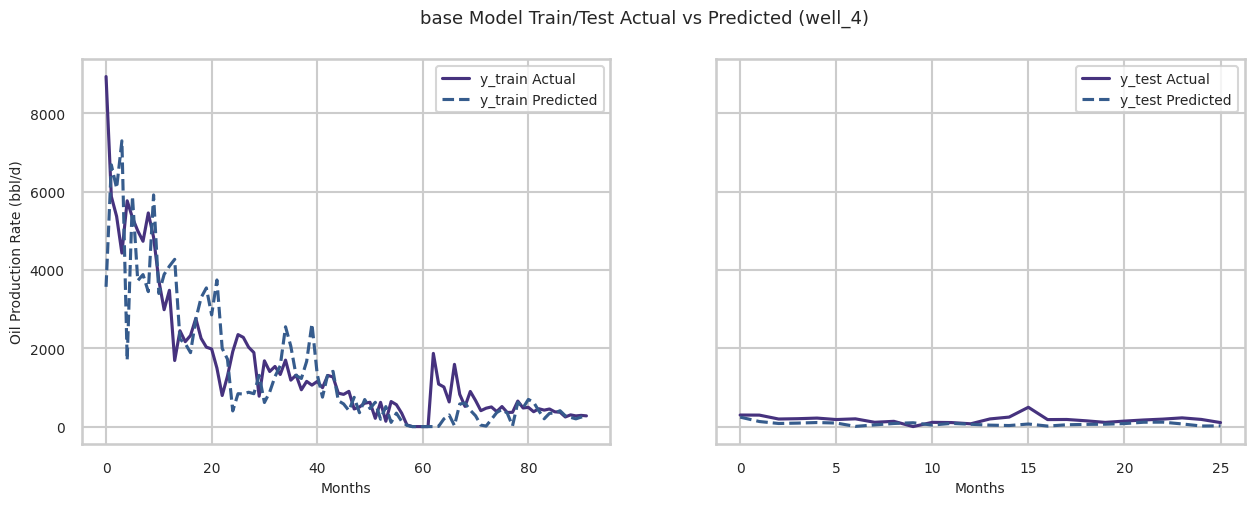

In [335]:
# Fit LSTM model and predict for well_4
predict_oil_production('base', train_test_dict, 'well_4', look_back, history)

#### Well 5 Base LSTM Prediction


Root Mean Squared Error Scores (well_5)

Train RMSE: 541.7
Test RMSE: 275.2


Actual vs Predicted Plots (well_5)



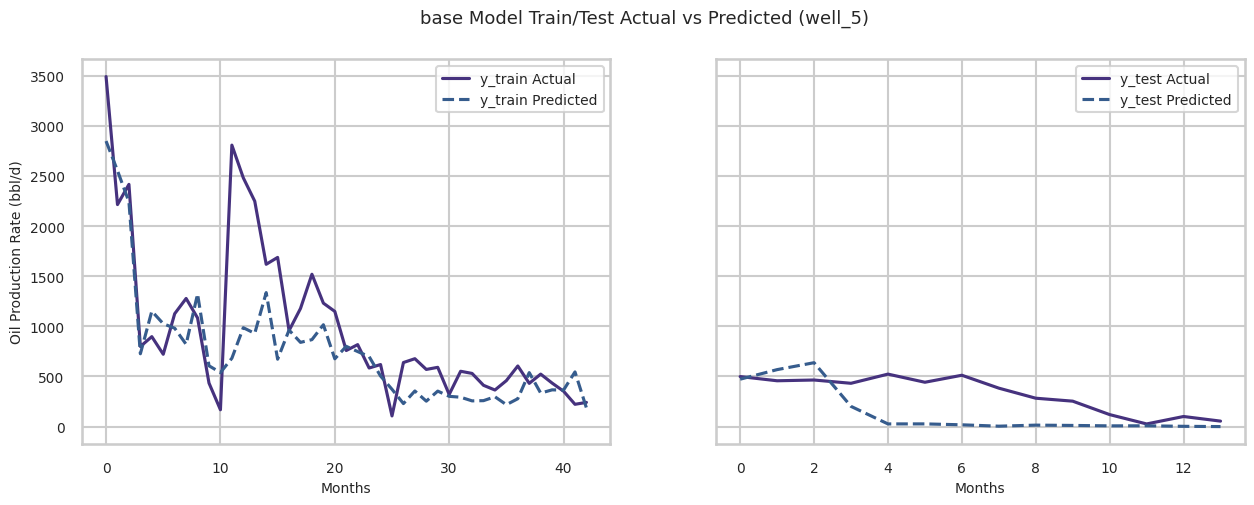

In [336]:
# Fit LSTM model and predict for well_5
predict_oil_production('base', train_test_dict, 'well_5', look_back, history)

> Across all five wells, the Base LSTM captures the broad decline trend in the training data reasonably well, but it consistently underestimates volatility and fails to reproduce the sharper peaks and operational fluctuations. The test-set forecasts are generally smoother and biased low, reflecting the model’s limited capacity with only 4 nodes to generalize higher-variance behaviour. Overall, the model provides a stable but conservative approximation of production, performing best on wells with smoother decline profiles and struggling on wells with larger early-time variability.

## HYPERPARAMETER TUNING
Using the selected model parameters of `lookback = 12`, `n_nodes = 4`, `learning_rate = 0.001`, and `dropout = 0.1` captured the general trends of the training data, but the fit could be improved. Next I'll tune the parameters using the Optuna bayesian optimizer to find the ideal model for each well.

#### Base Model Hyperparameter Tuning
- I'm using Optuna to tune the hyperparameters. Optuna is an automated hyperparameter optimization framework that uses techniques such as Bayesian sampling to efficiently search large parameter spaces. In this project, it evaluates many combinations of look-back windows, layer sizes, learning rates, and dropout values to identify the hyperparameter settings that minimize the Base LSTM model’s prediction error for each well.

*Hyperparameter Tuning Functions*
- `_evaluate_trial` - Runs a single Optuna trial by training an LSTM with sampled hyperparameters, evaluating its RMSE on the selected well, saving the best model, and returning the trial’s performance.
- `bayesian_tune_hyperparameters` - Manages the full Bayesian optimization loop for all wells, executes multiple trials per well, logs results, creates parallel coordinate plots, and outputs a consolidated RMSE summary.

In [337]:
# Directory to store per-trial trained models
MODEL_DIR = 'optuna_lstm_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Function to evaluate a single hyperparameter tuning trial
def _evaluate_trial(model_type, trial, train_test_dict, well_name):
    # Define parameter ranges to test 
    look_back = trial.suggest_categorical('look_back', [12, 24, 36])
    n_nodes = trial.suggest_categorical('n_nodes', [4, 8, 16])
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.5, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.1)

    # Get X_train and y_train datasets based on the look_back window
    X_train = np.concatenate(
        [train_test_dict[well_name][look_back]['X_train'] for well_name in train_test_dict.keys()],
        axis=0
    )
    y_train = np.concatenate(
        [train_test_dict[well_name][look_back]['y_train'] for well_name in train_test_dict.keys()],
        axis=0
    )

    # Create an LSTM model instance for the selected hyperparameters
    model = create_LSTM_model(
        model_type,
        n_nodes,
        look_back,
        learning_rate,
        dropout,
        X_train.shape[2]
    )

    # Unique path for this trial's best model
    model_path = os.path.join(
        MODEL_DIR,
        f'{model_type}_{well_name}_trial_{trial.number}.keras'
    )

    # Callbacks: EarlyStopping + ModelCheckpoint for best val_loss
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True
    )
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    # Fit LSTM model
    model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=(1 - SPLIT_RATIO),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping, checkpoint],
    )

    # Define the per-well X_test and y_test datasets
    X_test = train_test_dict[well_name][look_back]['X_test']
    y_test = train_test_dict[well_name][look_back]['y_test']
    y_test = np.exp(y_test) - SCALING_FACTOR

    # IMPORTANT: load the saved best model for this trial and evaluate with it
    best_model = keras.models.load_model(model_path)
    testPredict = best_model.predict(X_test, verbose=0)
    testPredict = np.exp(testPredict) - SCALING_FACTOR

    # Calculate the RMSE using the y_test and testPredict values
    test_rmse = np.sqrt(mean_squared_error(y_test, testPredict))

    # Store hyperparameters and model path in the trial for later use
    trial.set_user_attr('look_back', look_back)
    trial.set_user_attr('n_nodes', n_nodes)
    trial.set_user_attr('learning_rate', learning_rate)
    trial.set_user_attr('dropout', dropout)
    trial.set_user_attr('model_path', model_path)

    # Clear keras session
    keras.backend.clear_session()

    # Display the results of the current trial
    print(
        f'(look_back={look_back}, n_nodes={n_nodes}, '
        f'learning_rate={learning_rate:.4f}, dropout={dropout:.4f}) '
        f'-> RMSE={test_rmse:.4f}'
    )

    return float(test_rmse)

# Function to apply Bayesian hyperparameter tuning using the Optuna package
def bayesian_tune_hyperparameters(model_type):
    # Check if hyperparameters have already been tuned and load from directory
    # (used to optimize re-runs of the worksheet)
    csv_path = f'tuning_rmse_results_{model_type}.csv'
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    else: 
        # If the hyperparameters have not been previously tuned then continue to tuning
        trial_records = []
        well_names = df['well_name'].unique()

        # Loop over the well_names and conduct tuning trials
        for well_name in well_names:
            print(f'{model_type} Model Bayesian optimization trials for {well_name}:')

            # Optuna objective function to optimize
            def objective(trial):
                return _evaluate_trial(model_type, trial, train_test_dict, well_name)
            
            # Create an Optuna study instance and run tuning trials
            study = optuna.create_study(direction='minimize')
            study.optimize(
                objective,
                n_trials=N_TRIALS,
                show_progress_bar=True,
                gc_after_trial=True
            )

            # Save information on all trials, including the stored model path
            trial_records.extend(
                [
                    {
                        'well_name': well_name,
                        'trial': trial.number,
                        'look_back': trial.params.get('look_back'),
                        'n_nodes': trial.params.get('n_nodes'),
                        'learning_rate': trial.params.get('learning_rate'),
                        'dropout': trial.params.get('dropout'),
                        'test_rmse': trial.value,
                        'model_path': trial.user_attrs.get('model_path'),
                    }
                    for trial in study.trials
                ]
            )

            # Create a parallel coordinate plot summarizing the tuning results
            parallel_fig = plot_parallel_coordinate(
                study,
                params=['look_back', 'n_nodes', 'learning_rate', 'dropout'],
                target=lambda t: t.value,
                target_name='RMSE'
            ).update_layout(
                title_text=(
                    'Hyperparameter Tuning Parallel Coordinate Plot - '
                    f'{well_name.replace('_',' ').title()}'
                )
            )
            display(parallel_fig)

        # Save the RMSE scores for each trial and return a dataframe of RMSE scores
        rmse_df = pd.DataFrame(trial_records)
        rmse_df.to_csv(csv_path, index=False)
        return rmse_df

In [338]:
# Run Optuna hyperparameter tuning for the Base LSTM model
model_type = 'base'

# If tuning has not been completed then run, otherwise read tuning results from the .csv file
if not os.path.exists(f'tuning_rmse_results_{model_type}.csv'):
    # base_rmse_df = bayesian_tune_hyperparameters(model_type) # Comment this out to ensure tuning doesn't re-run if was previously completed
    pass
else:
    base_rmse_df = pd.read_csv('tuning_rmse_results_base.csv')

base_rmse_df

well_name  trial  look_back  n_nodes  learning_rate  dropout   test_rmse  \
0      well_1      0         24        4       0.002499      0.0  453.912785   
1      well_1      1         36        8       0.029829      0.5  476.803976   
2      well_1      2         12        4       0.005086      0.1  490.538122   
3      well_1      3         12        4       0.204127      0.0  568.291672   
4      well_1      4         36        8       0.001110      0.0  469.250570   
..        ...    ...        ...      ...            ...      ...         ...   
145    well_5     25         24        4       0.182294      0.4  774.300086   
146    well_5     26         24        4       0.014381      0.5  311.161234   
147    well_5     27         24        4       0.044718      0.4  246.327409   
148    well_5     28         24        4       0.277841      0.5  245.367860   
149    well_5     29         24       16       0.122950      0.0  316.468660   

                                        model_path  
0     optuna_lstm_models/base_well_1_trial_0.keras  
1     optuna_lstm_models/base_well_1_trial_1.keras  
2     optuna_lstm_models/base_well_1_trial_2.keras  
3     optuna_lstm_models/base_well_1_trial_3.keras  
4     optuna_lstm_models/base_well_1_trial_4.keras  
..                                             ...  
145  optuna_lstm_models/base_well_5_trial_25.keras  
146  optuna_lstm_models/base_well_5_trial_26.keras  
147  optuna_lstm_models/base_well_5_trial_27.keras  
148  optuna_lstm_models/base_well_5_trial_28.keras  
149  optuna_lstm_models/base_well_5_trial_29.keras  

[150 rows x 8 columns]

#### Base Model Hyperparameter Tuning RMSE Boxplots
- Below I generate Altair boxplots to visualize the distribution of the RMSE scores found during the tuning trials.
- Extreme outliers in `base_rmse_df` are hidden using a +/- 1.5 * IQR filter

In [339]:
# Function to filter outliers for each well using the 1.5*IQR rule
def rmse_iqr_filter(rmse_df):
    quartiles = rmse_df.groupby('well_name')['test_rmse'].quantile([0.25, 0.75]).unstack()
    quartiles.columns = ['q1', 'q3']
    quartiles['iqr'] = quartiles['q3'] - quartiles['q1']
    quartiles['lower'] = quartiles['q1'] - 1.5 * quartiles['iqr']
    quartiles['upper'] = quartiles['q3'] + 1.5 * quartiles['iqr']
    filtered_rmse_df = rmse_df.merge(quartiles[['lower', 'upper']], left_on='well_name', right_index=True)
    filtered_rmse_df = filtered_rmse_df[(filtered_rmse_df['test_rmse'] >= filtered_rmse_df['lower']) & (filtered_rmse_df['test_rmse'] <= filtered_rmse_df['upper'])]
    filtered_rmse_df = filtered_rmse_df.drop(columns=['lower', 'upper'])
    return filtered_rmse_df

# Function to create a set of boxplot to see the distribution of the RMSE scores attained in the hyperparameter tuning trials
def rmse_boxplots(rmse_df, model_type):    
    # Boxplot showing RMSE variation by well
    rmse_boxplot = (
        alt.Chart(rmse_df)
        .mark_boxplot(size=130)
        .encode(
            x=alt.X('well_name:N', title='Well'),
            y=alt.Y('test_rmse:Q', title='Test RMSE'),
            color=alt.Color('well_name:N', legend=None, scale=alt.Scale(scheme='viridis'))
        )
        .properties(
            width=800,
            height=400,
            title=alt.Title(
                f'{model_type} Model Hyperparameter Tuning RMSE Variation by Well',
                subtitle='Note: Extreme outliers have been hidden using a +/- 1.5 * IQR filter',
                fontSize=20,
                anchor='start'
            )
        )
    )
    return rmse_boxplot

# Create boxplots summarizing the Base LSTM model's RMSE tuning results
base_rmse_df = rmse_iqr_filter(base_rmse_df)
rmse_boxplots(base_rmse_df, 'Base')

alt.Chart(...)

> The RMSE distributions show substantial variation across wells, indicating that the Base LSTM fits some wells more effectively than others. Wells 2 and 4 exhibit the lowest and most stable RMSE ranges, while Wells 1, 3, and 5 show higher error levels and greater spread, reflecting more complex or volatile production behavior.

#### Base Model Hyperparameter Tuning Parallel Coordinate Plots
- A parallel coordinate plot visualizes high-dimensional data by mapping each variable to a vertical axis and drawing a line for each trial that connects its values across all axes.
- By scanning how lines rise, fall, and cluster between axes, you can see which hyperparameter combinations correspond to lower or higher **test RMSE** values.
- The x-axis represents the **test RMSE** scores for each tuning trial, LSTM model dropout rate, LSTM model learning rate, look-back window, and number of LSTM nodes.
- These charts allows you to visually assess how each parameter setting influences model performance.

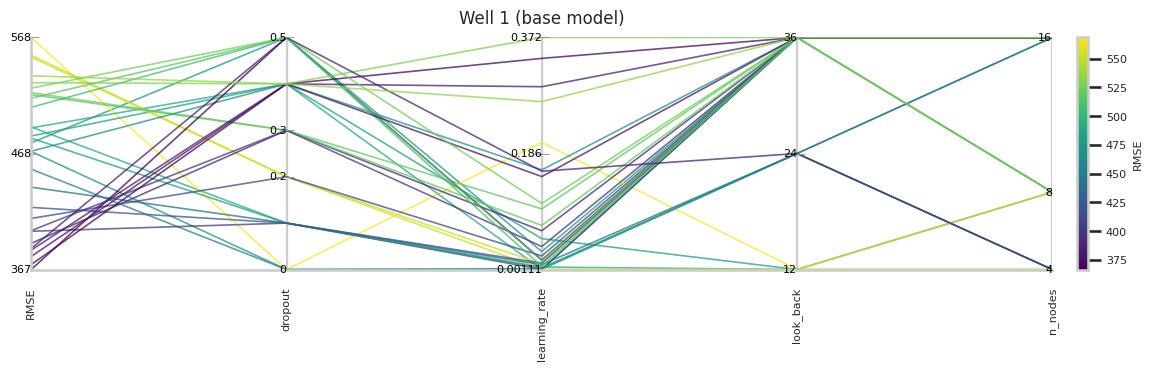

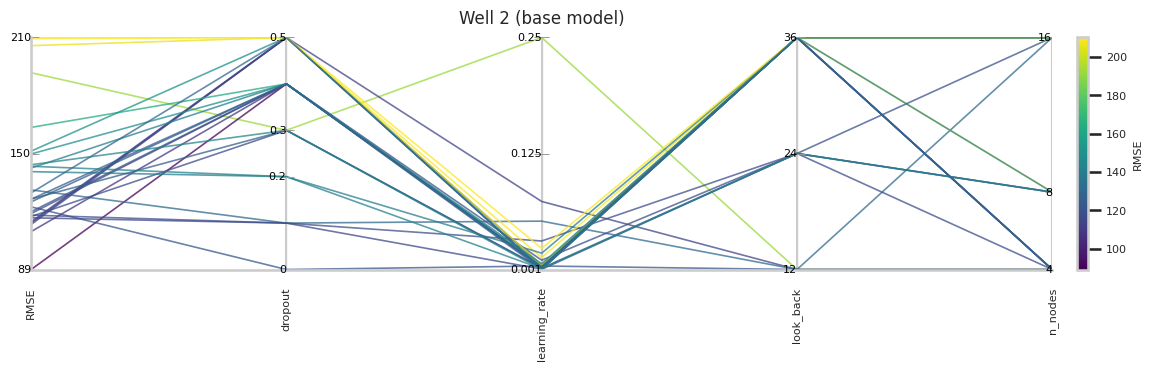

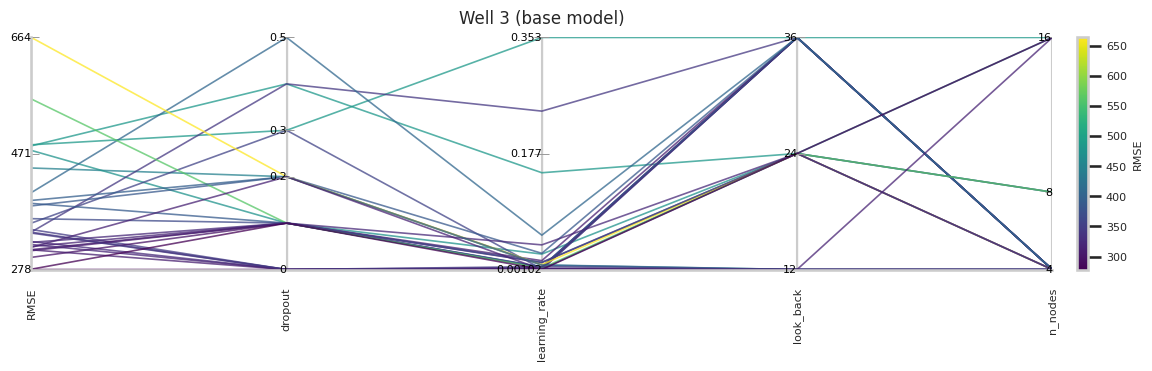

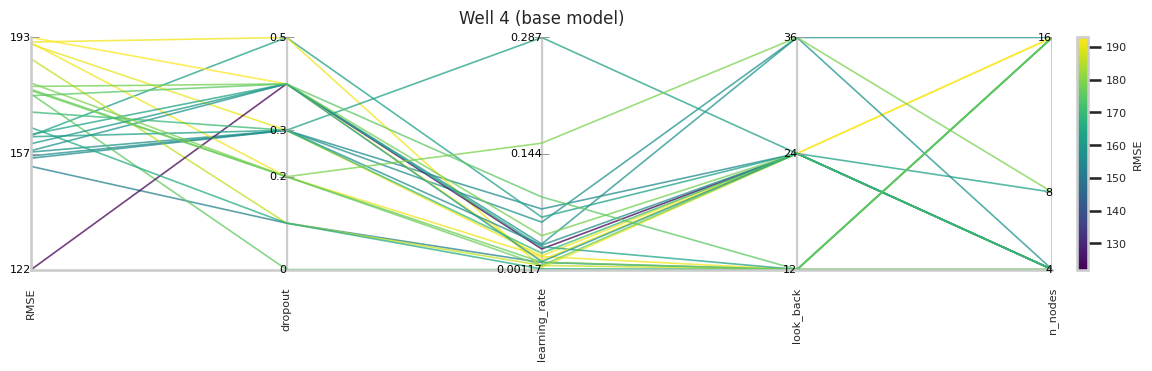

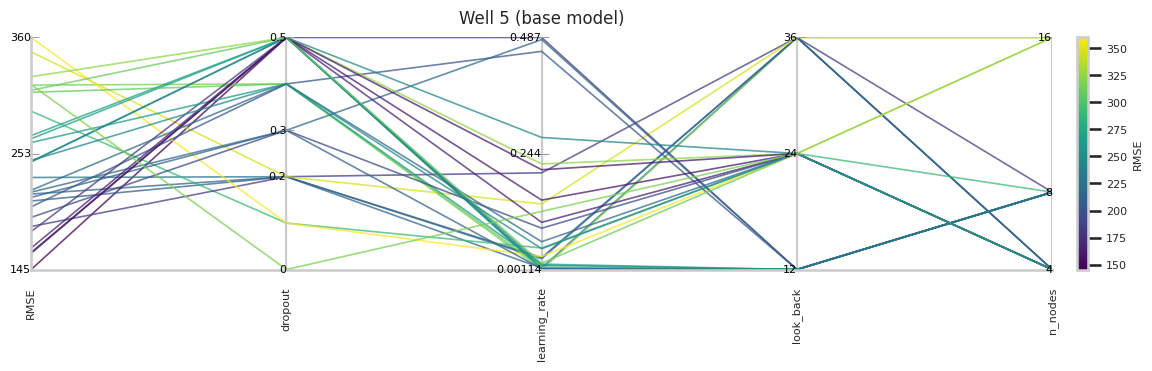

In [340]:
# Function to generate a hyperparameter tuning parallel coordinate plot for each well_name and model_type
def create_parallel_plots(rmse_df, model_type):
    axes = ['RMSE', 'dropout', 'learning_rate', 'look_back', 'n_nodes']

    # Loop over each well_name
    for well_name in rmse_df['well_name'].unique():
        df_well = rmse_df[rmse_df['well_name'] == well_name].copy()
        df_well['RMSE'] = df_well['test_rmse'].astype(float)
        df_well = df_well[axes + ['trial']]

        # Normalize values for each vertical axis
        df_norm = pd.DataFrame(index=df_well.index)
        ranges = {}
        for a in axes:
            col = df_well[a].astype(float)
            vmin, vmax = col.min(), col.max()
            ranges[a] = (vmin, vmax)
            df_norm[a] = (col - vmin) / (vmax - vmin)

        x = np.arange(len(axes))

        rmse = df_well['RMSE'].values
        norm = plt.Normalize(rmse.min(), rmse.max())
        cmap = plt.cm.viridis

        fig, ax = plt.subplots(figsize=(13, 4))
        ax.set_facecolor('white')
        ax.grid(axis='y', color='0.9', linewidth=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        for xi in x:
            ax.axvline(x=xi, color='0.85', linewidth=1, zorder=0)

        for idx, row in df_norm.iterrows():
            y = [row[a] for a in axes]
            color = cmap(norm(df_well.loc[idx, 'RMSE']))
            ax.plot(x, y, color=color, linewidth=1.2, alpha=0.75, zorder=1)

        ax.set_xticks(x)
        ax.set_xticklabels(axes, rotation=90, fontsize=8)
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim(0, 1)

        ax.set_title(
            f'{well_name.replace('_', ' ').title()} ({model_type} model)',
            fontsize=12,
            pad=10,
        )

        # Add original tick marks & labels to vertical axis
        for j, a in enumerate(axes):
            xi = x[j]
            vmin, vmax = ranges[a]
            vals = np.unique(df_well[a].astype(float).values)

            if a in ['RMSE', 'learning_rate'] and len(vals) > 3:
                ticks_vals = np.array([vmin, 0.5 * (vmin + vmax), vmax])
            else:
                if len(vals) <= 4:
                    ticks_vals = vals
                else:
                    idxs = np.linspace(0, len(vals) - 1, 4).round().astype(int)
                    ticks_vals = vals[idxs]

            for v in ticks_vals:
                yn = (v - vmin) / (vmax - vmin)
                ax.hlines(yn, xi - 0.03, xi + 0.03, color='0.6', linewidth=0.7, zorder=2)
                if a == 'learning_rate':
                    label = f'{v:.3g}'
                elif a == 'RMSE':
                    label = f'{v:.0f}'
                else:
                    label = f'{int(v) if float(v).is_integer() else v:.3g}'
                ax.text(xi, yn, label, fontsize=8, ha='right', va='center', color='black')

        # Plot parallel coordinate plots
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, pad=0.02)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('RMSE', fontsize=8)

        plt.tight_layout()
        plt.show()

# Display hyperparameter tuning RMSE results on parallel coordinate plots
create_parallel_plots(base_rmse_df, 'base')

> - **Well 1**: The lowest-error trials cluster around a small learning rate near 0.001 and zero dropout, with moderate look-back windows (12 or 24) and lower node counts (4 or 8) generally outperforming larger configurations.
> - **Well 2**: RMSE is uniformly lower across trials, and the best results again occur at the smallest learning rate with dropout near 0–0.2; look-back shows little separation, although 12 and 24 slightly outperform 36.
> - **Well 3**: Exhibits higher variability, the best-performing trials consistently use the smallest learning rate, low dropout, and the smallest node count, while larger look-back windows tend to increase error.
> - **Well 4**: This has the lowest RMSE values appear tightly clustered, with all good-performing trials sharing the smallest learning rate, minimal dropout, and look-back values of 12 or 24; node count shows almost no influence on performance.
> - **Well 5**: The best-performing trials again rely on low learning rates and low dropout, but unlike the other wells, the optimal look-back values are more evenly split, and node count shows a slightly stronger pattern, with 4 or 8 nodes producing lower RMSE than 16.
> - Overall, across all five wells, the strongest consistent trends are that the smallest learning rate and lowest dropout reliably yield the lowest RMSE, while the effects of look-back and node count vary more by well.

#### Apply Best Base Model Hyperparameters
- Hyperparameters are applied based on the best RMSE score for each well
- Since model is being refit after hyperparameter tuning the train and test RMSE values may stochastically vary from what Optuna produces

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0162
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/base_well_1_trial_20.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 378.5
Test RMSE: 366.8


Actual vs Predicted Plots (well_1)



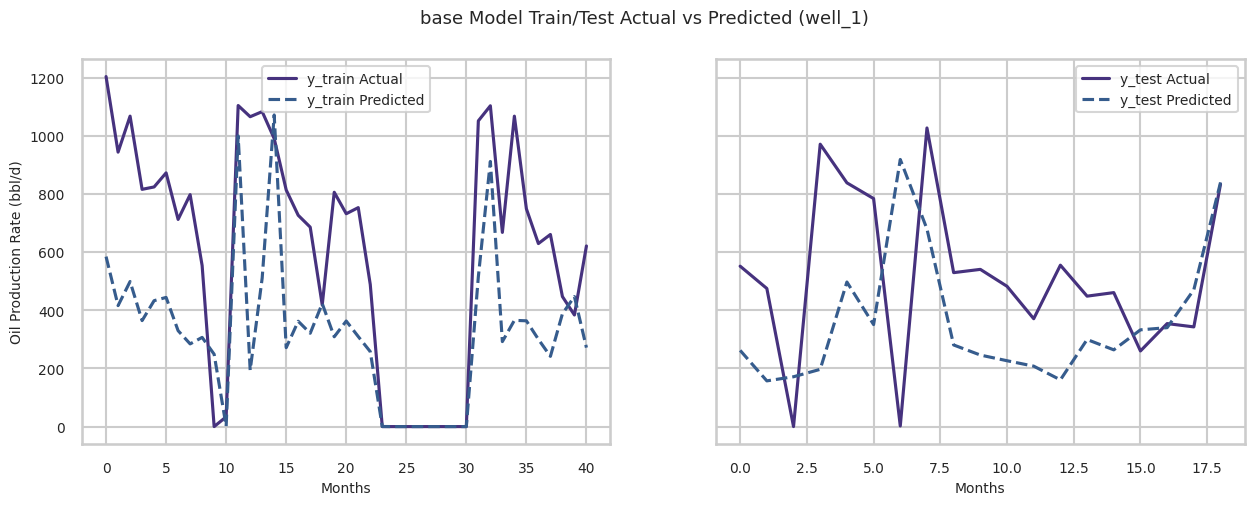

In [341]:
# Function to fit and predict an LSTM model using the best hyperparameter tuning
def apply_best_hyperparameters(rmse_df, train_test_dict, well_name, model_type):
    # Find the set of best hyperparameters
    best_entry = rmse_df[rmse_df['well_name'] == well_name].sort_values('test_rmse').iloc[0]

    # Extract the best hyperparameters
    look_back = int(best_entry['look_back'])
    n_nodes = int(best_entry['n_nodes'])
    learning_rate = float(best_entry['learning_rate'])
    dropout = float(best_entry['dropout'])
    model_path = best_entry.get('model_path', None)

    print(
        f'Best hyperparameters for {well_name}:\n'
        f'    look_back = {look_back}\n'
        f'    n_nodes = {n_nodes}\n'
        f'    learning_rate = {learning_rate:.4f}\n'
        f'    dropout = {dropout:.4f}'
    )

    # Load best tuned model from directory
    if isinstance(model_path, str) and os.path.exists(model_path):
        print(f'Loading best Optuna model from: {model_path}')
        best_model = keras.models.load_model(model_path)

        class DummyHistory:
            def __init__(self, model):
                self.model = model
                self.history = {}

        history = DummyHistory(best_model)

        # Use the loaded best model for prediction / plotting
        predict_oil_production(model_type, train_test_dict, well_name, look_back, history)

apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_1', 'base')

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0030
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/base_well_2_trial_2.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 599.6
Test RMSE: 89.3


Actual vs Predicted Plots (well_2)



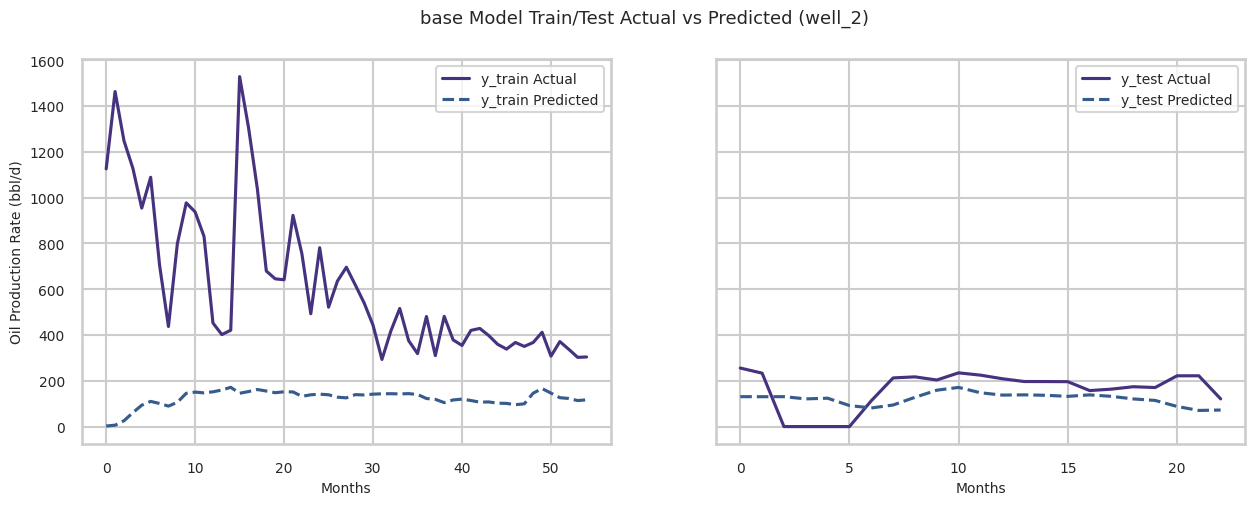

In [342]:
# Apply best base tuned hyperparameters to Well 2
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_2', 'base')

Best hyperparameters for well_3:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0023
    dropout = 0.0000
Loading best Optuna model from: optuna_lstm_models/base_well_3_trial_23.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 1,021.6
Test RMSE: 278.4


Actual vs Predicted Plots (well_3)



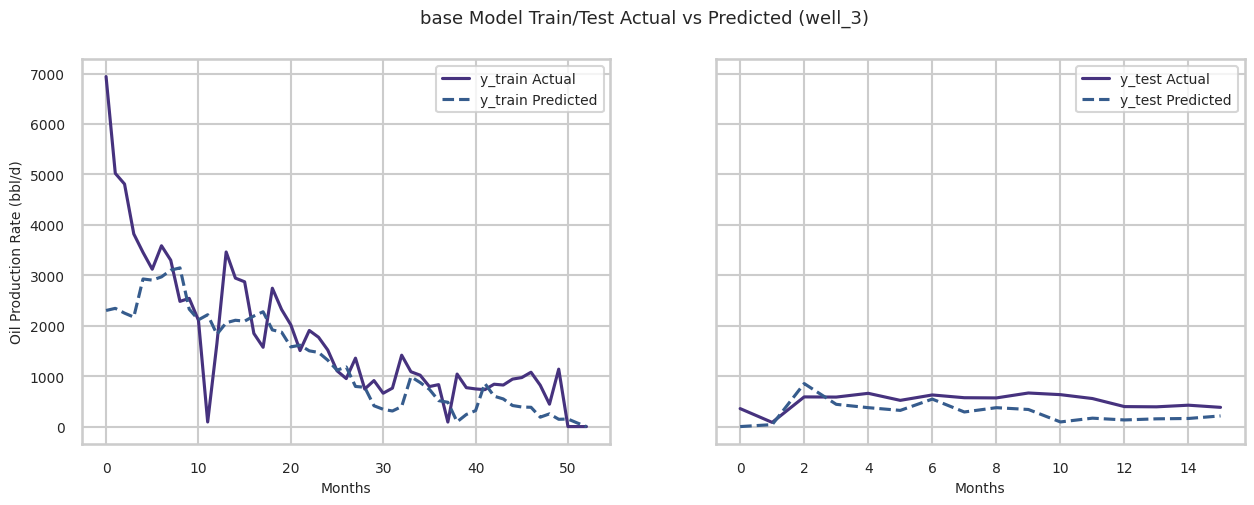

In [343]:
# Apply best base tuned hyperparameters to Well 3
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_3', 'base')

Best hyperparameters for well_4:
    look_back = 24
    n_nodes = 4
    learning_rate = 0.0265
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/base_well_4_trial_15.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 1,253.6
Test RMSE: 122.0


Actual vs Predicted Plots (well_4)



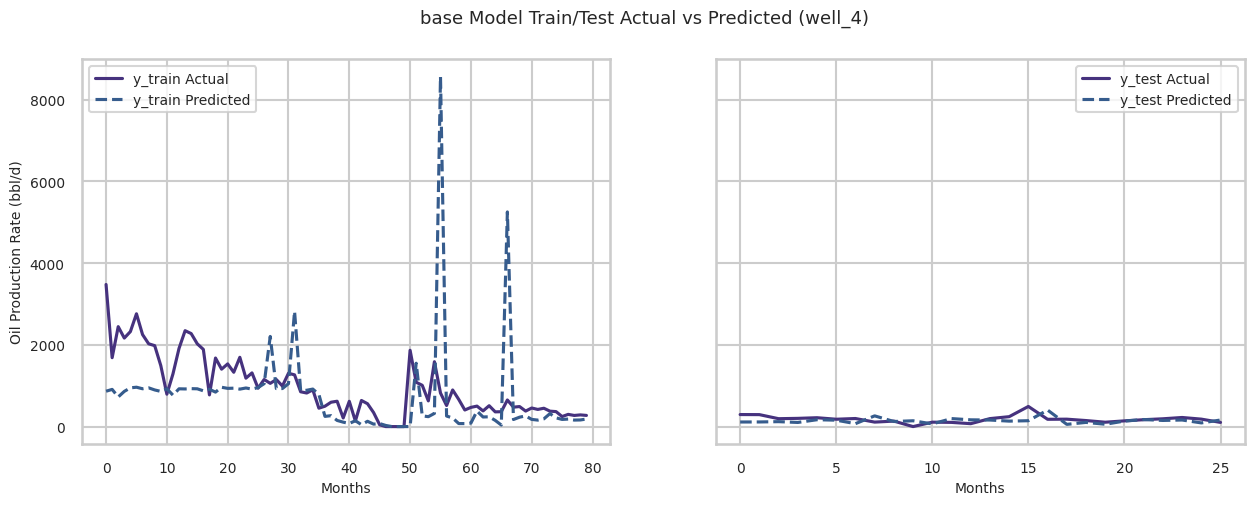

In [344]:
# Apply best base tuned hyperparameters to Well 4
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_4', 'base')

Best hyperparameters for well_5:
    look_back = 12
    n_nodes = 8
    learning_rate = 0.0036
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/base_well_5_trial_2.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 793.6
Test RMSE: 145.4


Actual vs Predicted Plots (well_5)



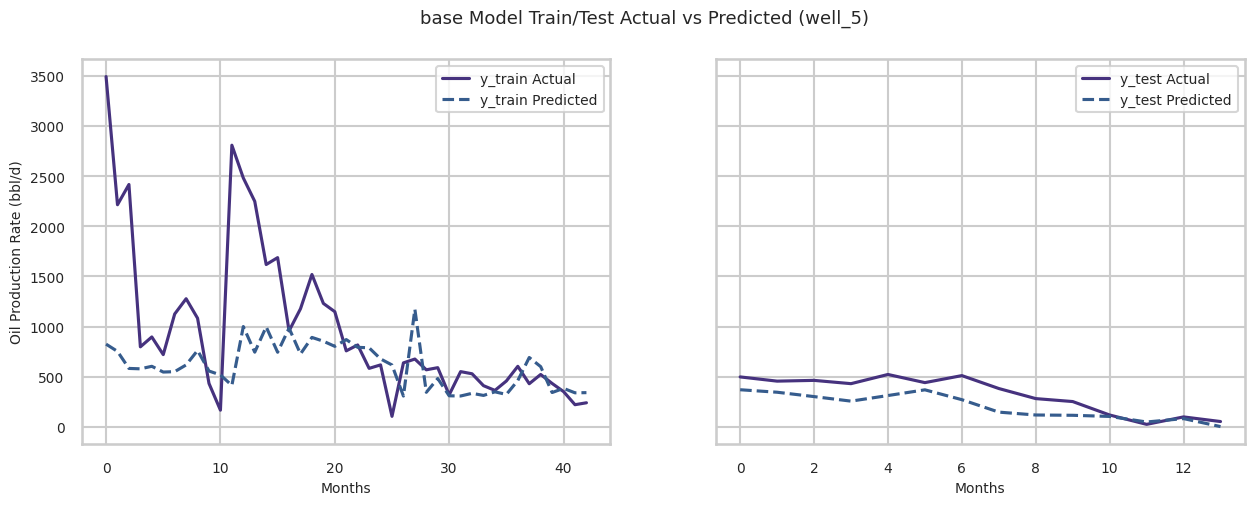

In [345]:
# Apply best base tuned hyperparameters to Well 5
apply_best_hyperparameters(base_rmse_df, train_test_dict, 'well_5', 'base')

> The hyperparameter-tuned Base LSTM models show clear improvements in test performance across all wells, with each well converging on a unique combination of look-back window, node count, learning rate, and dropout that reflects its production behavior. Wells 2, 4, and 5 achieve particularly low test RMSE values, indicating that the optimized models capture their smoother decline trends effectively, while Wells 1 and 3 remain more challenging due to their higher volatility and operational interruptions. Overall, tuning enables the models to generalize far better on test data than the untuned base versions, especially for wells with more stable production profiles.

## ALTERNATIVE LSTM MODELS

#### Bidirectional LSTM
- A model that reads the production sequence both forward and backward to gain a more complete picture of the trend.
- This allows it to learn from what happens before and after each point, improving its ability to detect smoother patterns.

In [346]:
# Run Optuna hyperparameter tuning for the Bidirectional LSTM model
model_type = 'bidirectional'

# If tuning has not been completed then run, otherwise read tuning results from the .csv file
if not os.path.exists(f'tuning_rmse_results_{model_type}.csv'):
    # bidirectional_rmse_df = bayesian_tune_hyperparameters(model_type) # Comment this out to ensure tuning doesn't re-run if was previously completed
    pass
else:
    bidirectional_rmse_df = pd.read_csv(f'tuning_rmse_results_{model_type}.csv')

# Display RMSE distributions
bidirectional_rmse_df = rmse_iqr_filter(bidirectional_rmse_df)
rmse_boxplots(bidirectional_rmse_df, model_type)

alt.Chart(...)

> The RMSE distributions for the bidirectional model show similar well-to-well variation as the base model, with Wells 2 and 4 achieving the lowest and tightest error ranges, while Wells 1 and 3 exhibit higher and more dispersed RMSE values. This suggests that the bidirectional architecture benefits smoother wells but continues to struggle on wells with more irregular production behavior.

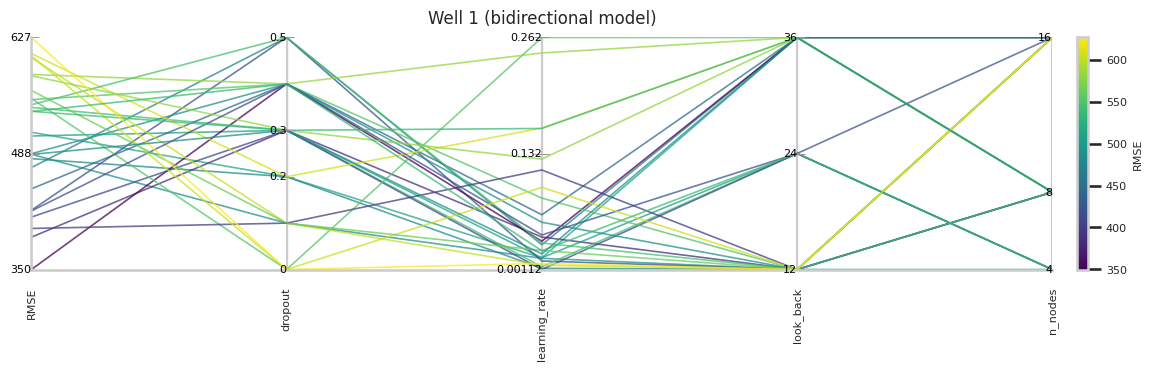

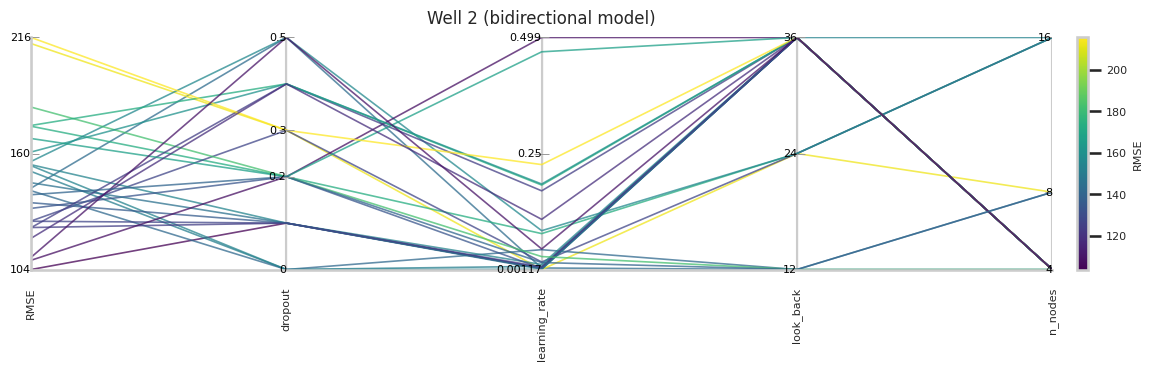

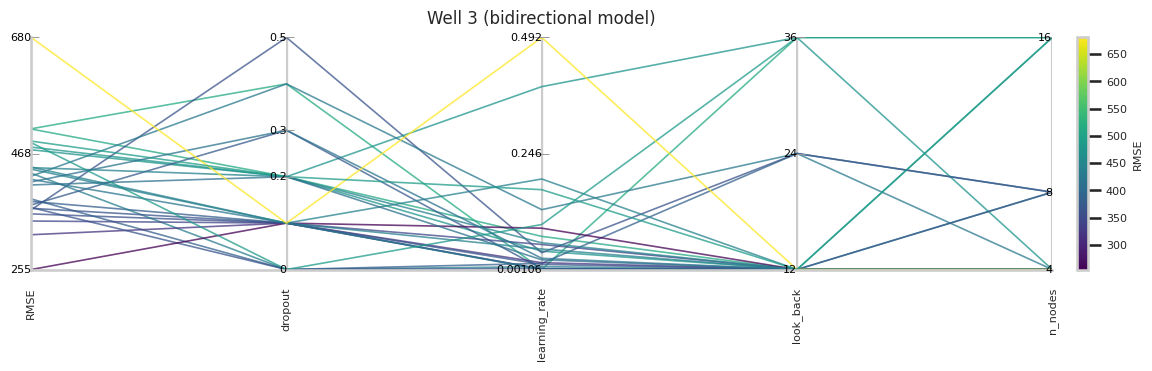

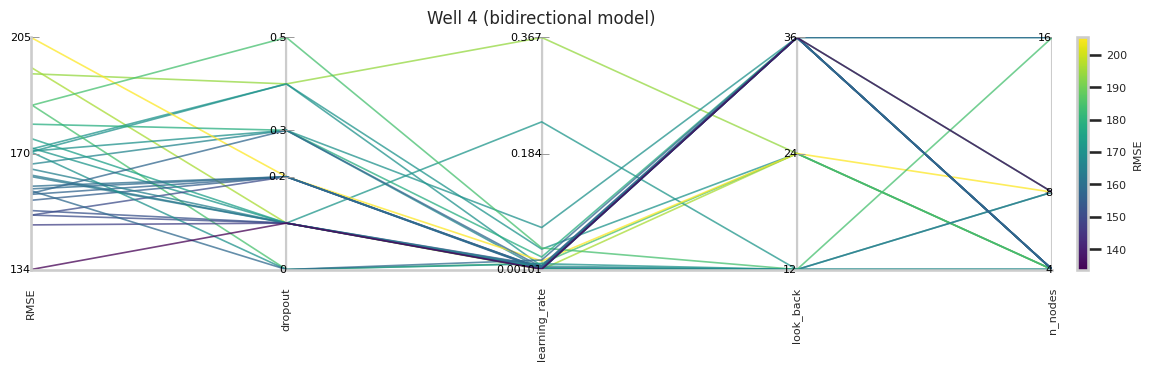

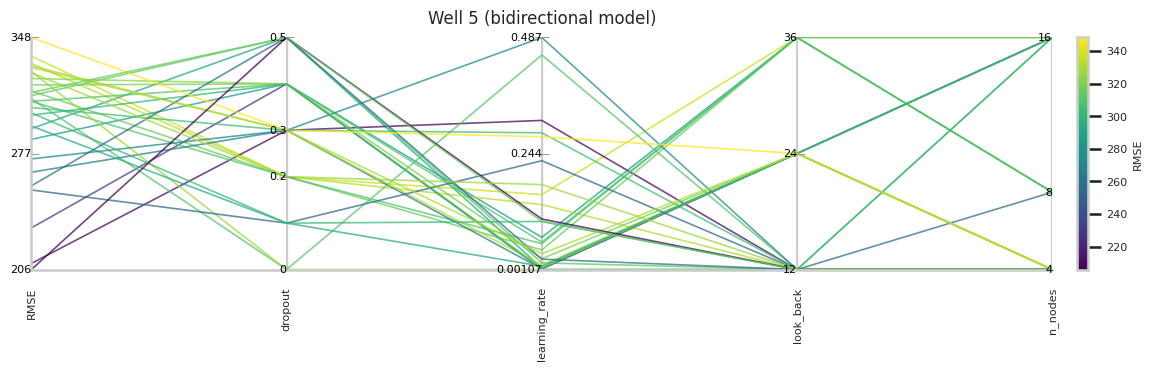

In [347]:
# Display hyperparameter tuning RMSE results on parallel coordinate plots
create_parallel_plots(bidirectional_rmse_df, 'bidirectional')

> Across all five wells, the bidirectional LSTM’s parallel coordinate plots show consistent patterns in which the lowest-error trials almost always correspond to the smallest learning rate and minimal dropout. For Wells 1 and 3, RMSE remains relatively high and widely spread, with no strong advantage from larger look-back windows or higher node counts, reflecting the difficulty of modeling their more volatile production histories. Wells 2 and 4 show the clearest clusters of low-RMSE trials, where small learning rates, low dropout, and shorter look-back windows (12–24 months) dominate, indicating that the bidirectional architecture is best suited to smoother decline trends. Well 5 exhibits an intermediate pattern, where low learning rate and low dropout again drive the best outcomes, but node count and look-back configuration have more mixed effects.

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0329
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_1_trial_7.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 405.0
Test RMSE: 349.7


Actual vs Predicted Plots (well_1)



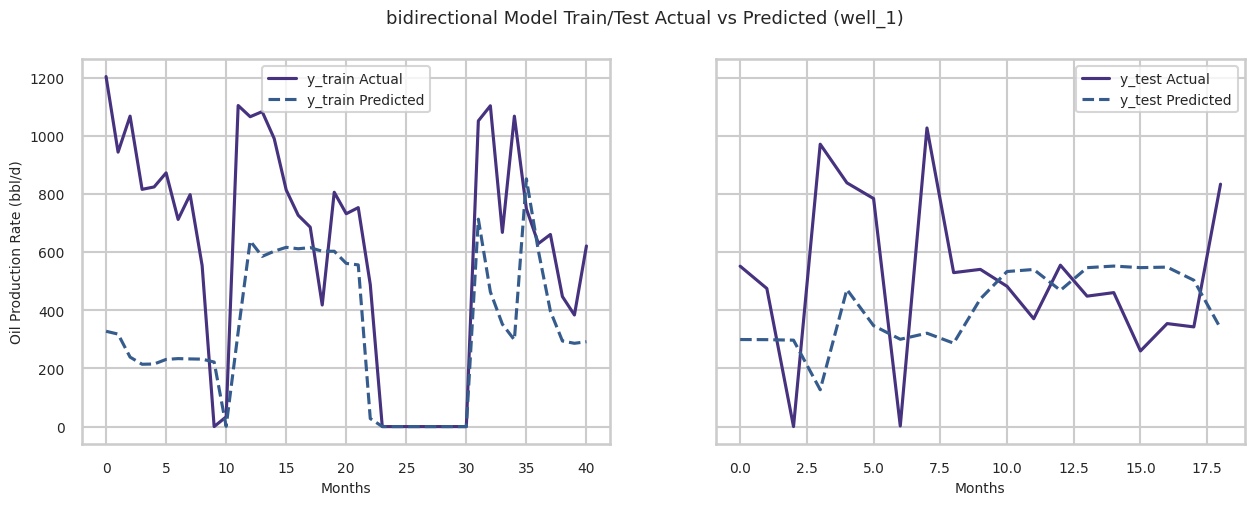

In [348]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0035
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_2_trial_3.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 1,001.9
Test RMSE: 103.7


Actual vs Predicted Plots (well_2)



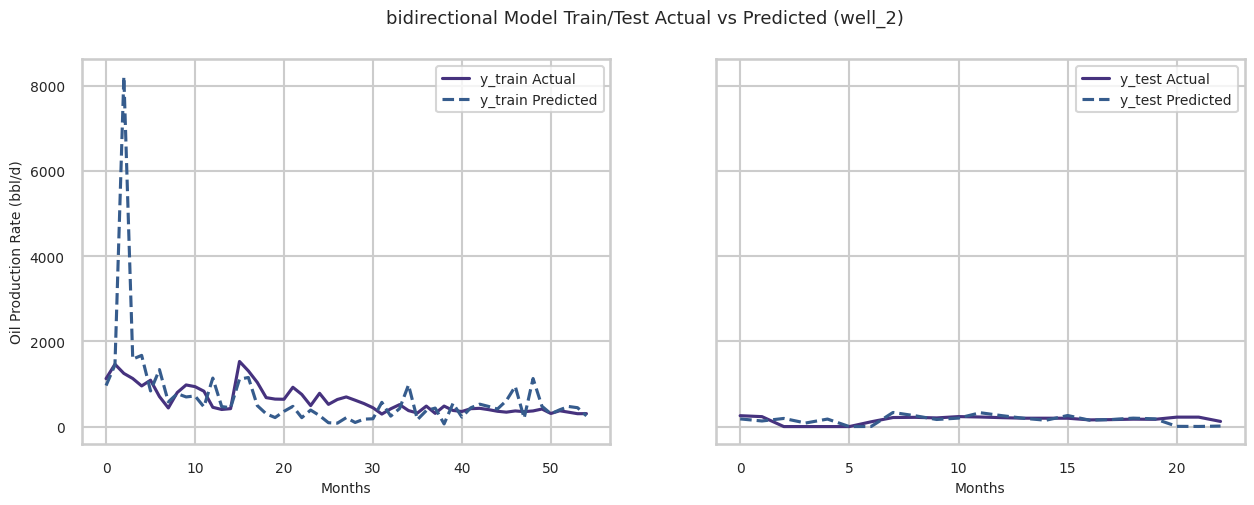

In [349]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0885
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_3_trial_19.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 1,572.7
Test RMSE: 254.8


Actual vs Predicted Plots (well_3)



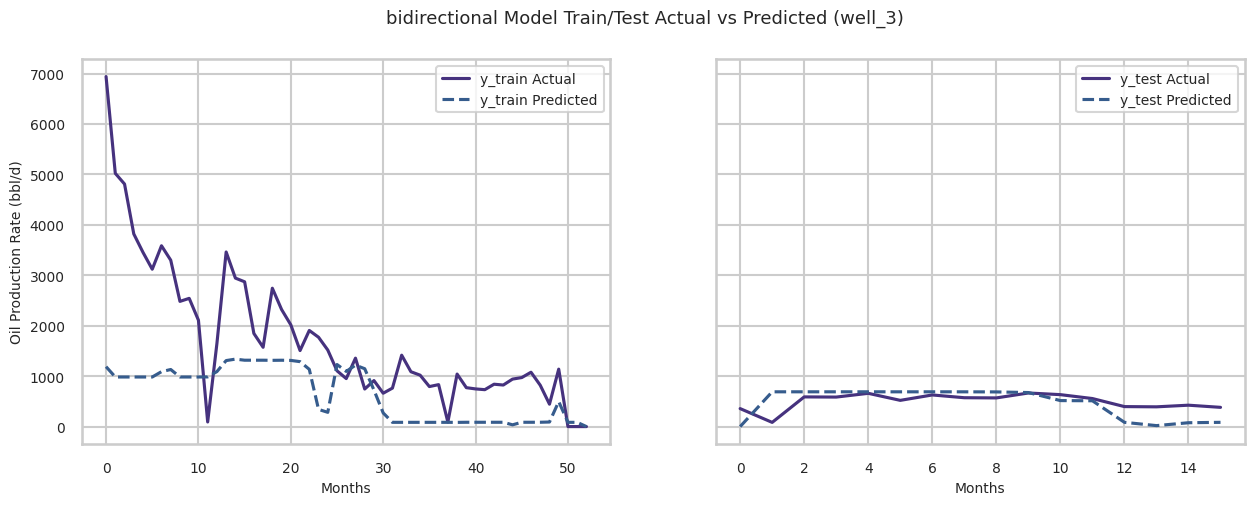

In [350]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0016
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_4_trial_29.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 631.3
Test RMSE: 133.8


Actual vs Predicted Plots (well_4)



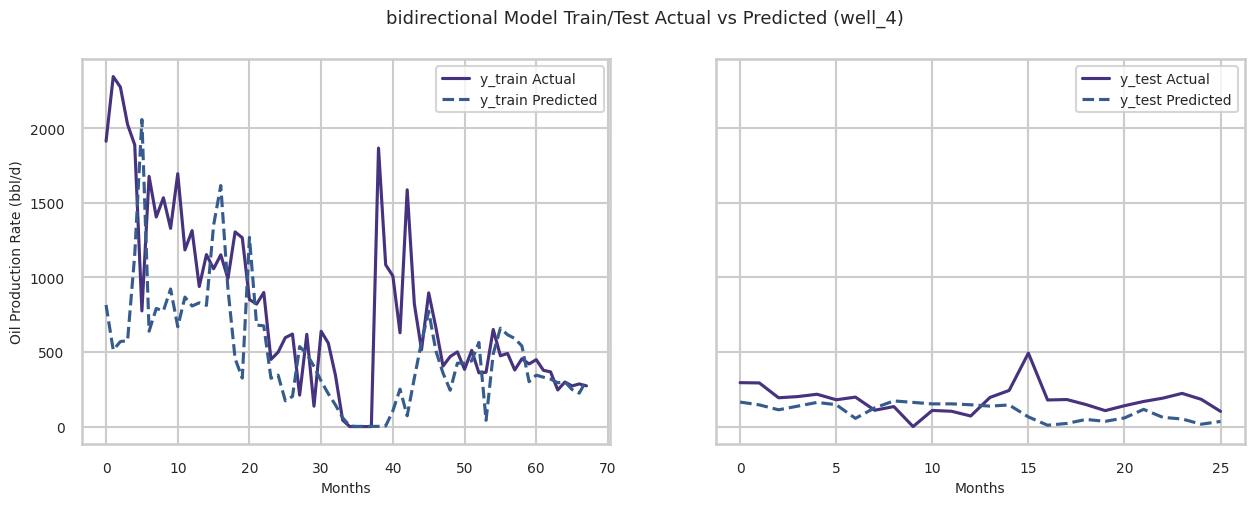

In [351]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.1068
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/bidirectional_well_5_trial_27.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 648.7
Test RMSE: 205.9


Actual vs Predicted Plots (well_5)



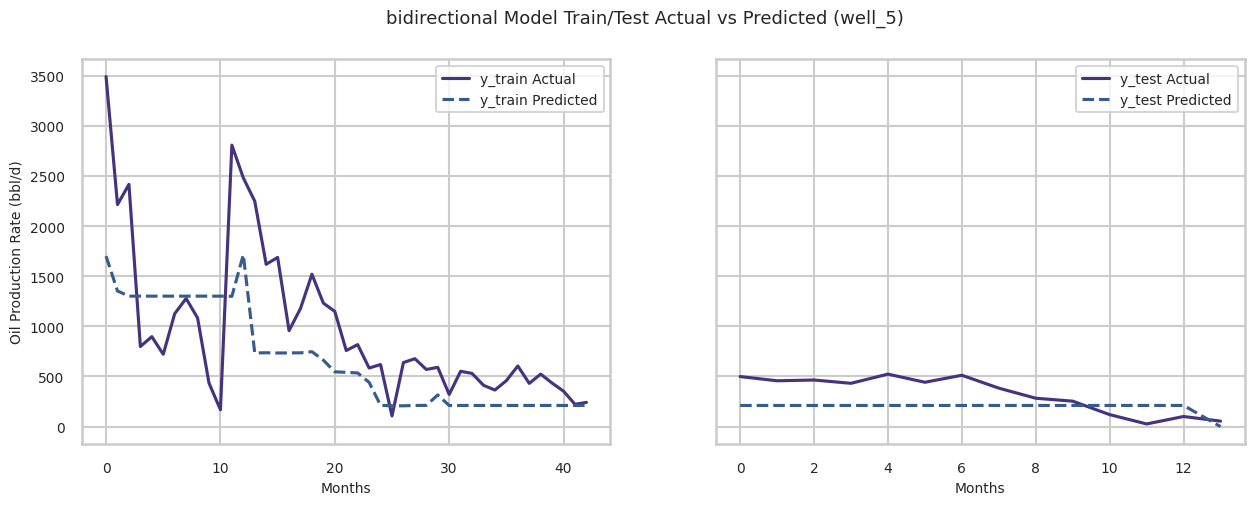

In [352]:
# Apply best Bidirectional LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(bidirectional_rmse_df, train_test_dict, 'well_5', model_type)

> The tuned bidirectional LSTM models deliver strong generalization across the test sets, particularly for Wells 2 and 4, where test RMSE values fall near or just above 100 bbl/d and the predicted curves closely follow the observed decline patterns. Wells 1 and 5 show moderate improvements but still underestimate volatility and peak values, while Well 3 remains the most difficult to model due to its sharp early-time fluctuations and operational interruptions. Overall, bidirectional tuning improves test performance across all wells but maintains the same pattern observed previously: smoother wells benefit the most, while highly variable wells remain challenging.

#### Stacked LSTM
- A deeper version of the LSTM where multiple layers are stacked to learn more complex behaviors.
- Each layer extracts increasingly detailed temporal patterns, helping the model capture multi-scale production dynamics.
- In this analysis I've created a stack of 2 layers where the **first layer has twice as many LSTM cells as the second layer**.

In [353]:
# Run Optuna hyperparameter tuning for the Stacked LSTM model
model_type = 'stacked'

# If tuning has not been completed then run, otherwise read tuning results from the .csv file
if not os.path.exists(f'tuning_rmse_results_{model_type}.csv'):
    # stacked_rmse_df = bayesian_tune_hyperparameters(model_type) # Comment this out to ensure tuning doesn't re-run if was previously completed
    pass
else:
    stacked_rmse_df = pd.read_csv(f'tuning_rmse_results_{model_type}.csv')

# Display RMSE distributions
stacked_rmse_df = rmse_iqr_filter(stacked_rmse_df)
rmse_boxplots(stacked_rmse_df, model_type)

alt.Chart(...)

> The stacked LSTM model shows a similar well-by-well pattern to the other architectures, with Wells 2 and 4 achieving the lowest and tightest RMSE distributions, indicating more stable fits. Wells 1 and 3 again produce higher and more variable errors, while Well 5 lands in the middle, reflecting moderate sensitivity to hyperparameter choices.

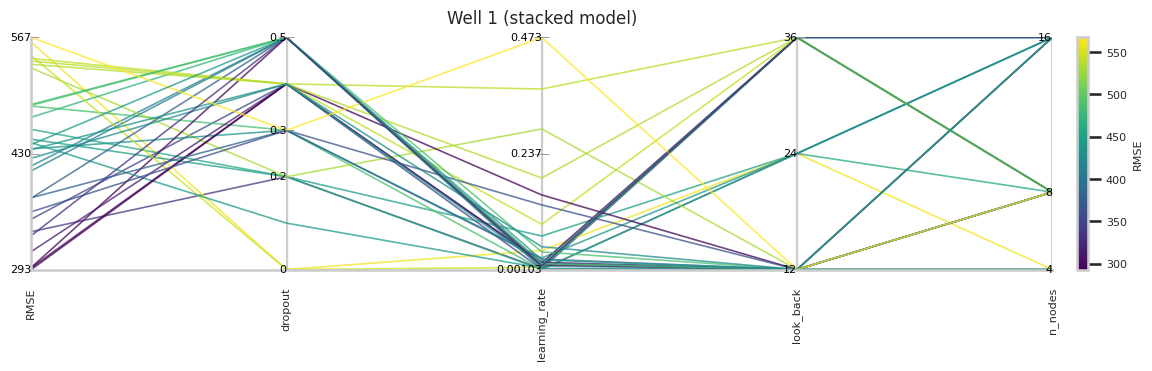

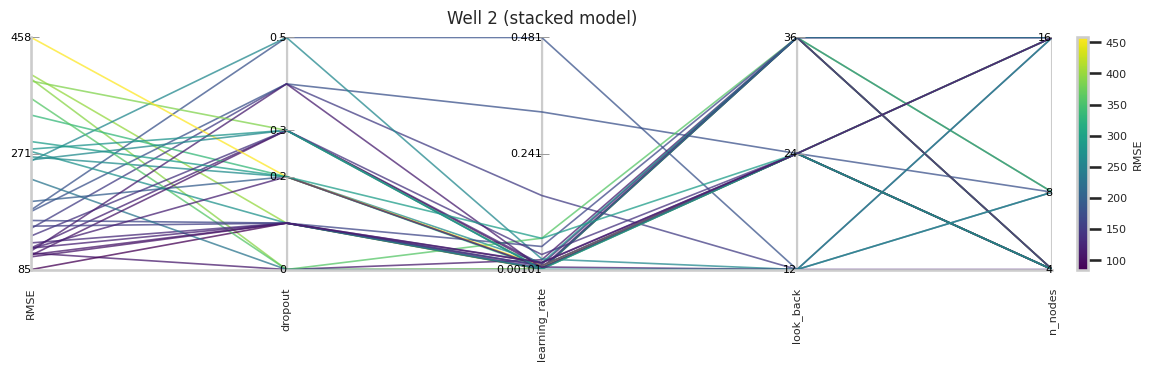

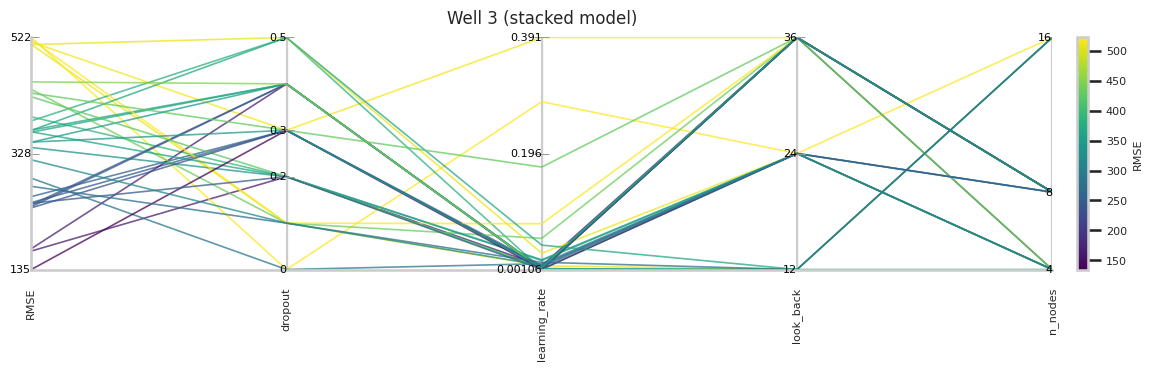

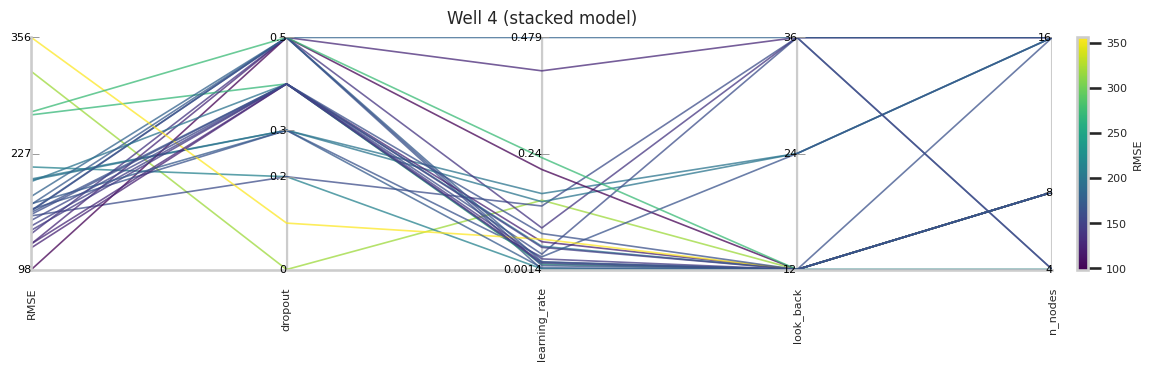

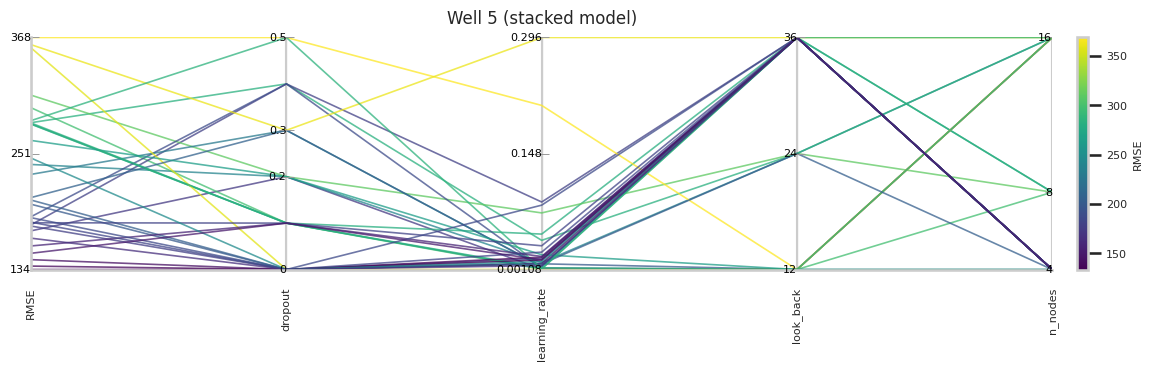

In [354]:
# Display hyperparameter tuning RMSE results on parallel coordinate plots
create_parallel_plots(stacked_rmse_df, 'stacked')

> Across all wells, the stacked LSTM parallel coordinate plots show that the lowest RMSE values consistently align with very small learning rates and zero dropout, confirming that deeper recurrent architectures remain sensitive to aggressive regularization or large update steps. Wells 2 and 4 again show the clearest low-error clusters, where almost all of the best trials share learning rates near 0.001 and look-back windows of 12–24 months. Wells 1 and 3 exhibit broader spreads and higher RMSEs, with no strong advantage from larger node counts or longer look-back windows, while Well 5 sits in the middle, showing that performance improves mainly when learning rate and dropout remain at their minimal settings.

Best hyperparameters for well_1:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0145
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/stacked_well_1_trial_13.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 389.1
Test RMSE: 293.2


Actual vs Predicted Plots (well_1)



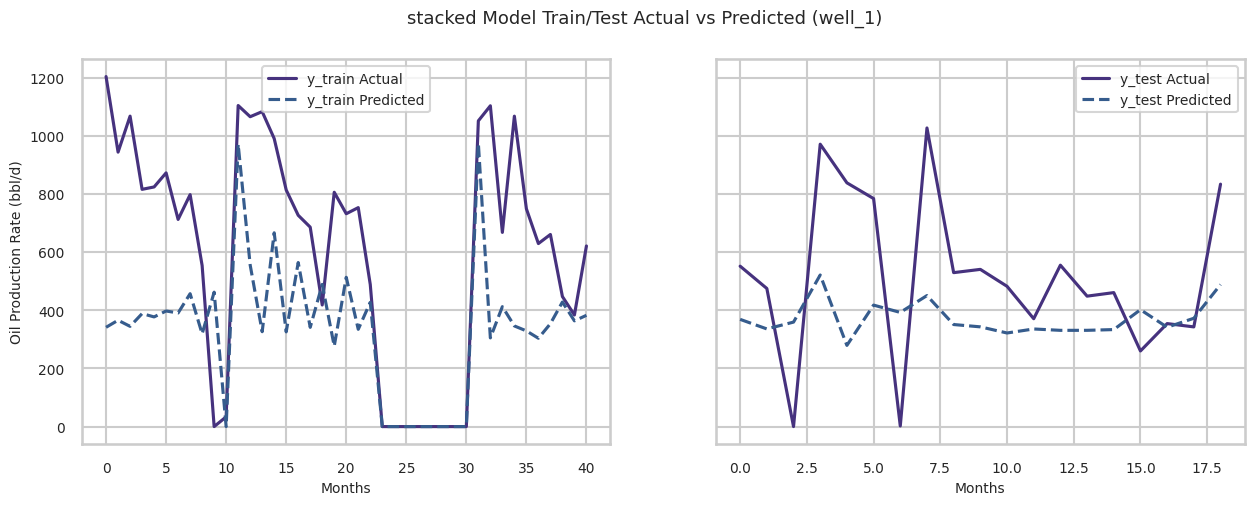

In [355]:
# Apply best Stacked LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 36
    n_nodes = 16
    learning_rate = 0.0019
    dropout = 0.1000
Loading best Optuna model from: optuna_lstm_models/stacked_well_2_trial_9.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 578.9
Test RMSE: 84.9


Actual vs Predicted Plots (well_2)



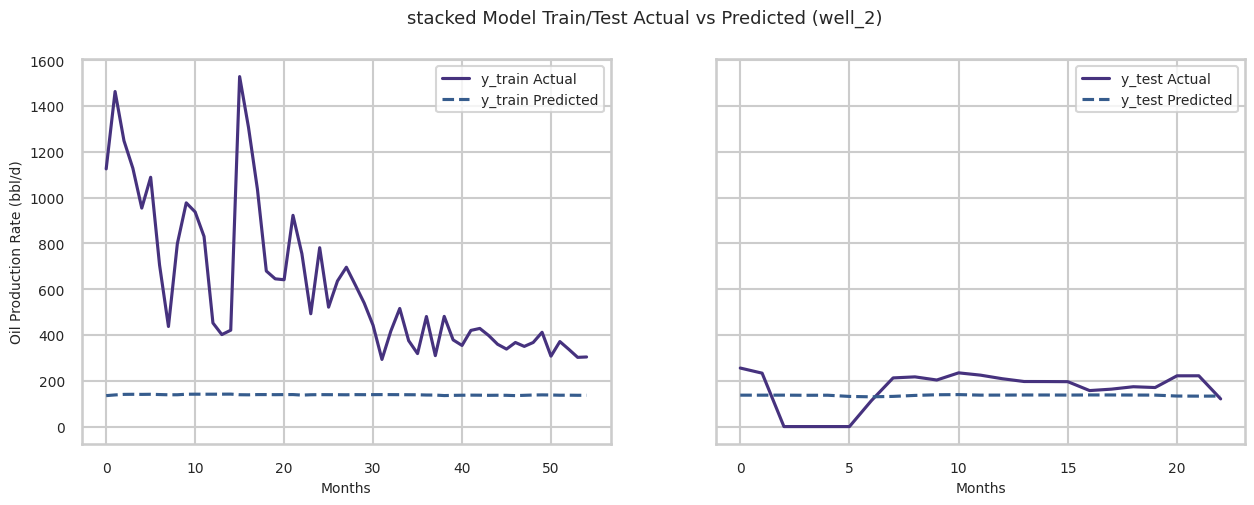

In [356]:
# Apply best Stacked LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 36
    n_nodes = 8
    learning_rate = 0.0016
    dropout = 0.3000
Loading best Optuna model from: optuna_lstm_models/stacked_well_3_trial_24.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 429.8
Test RMSE: 134.8


Actual vs Predicted Plots (well_3)



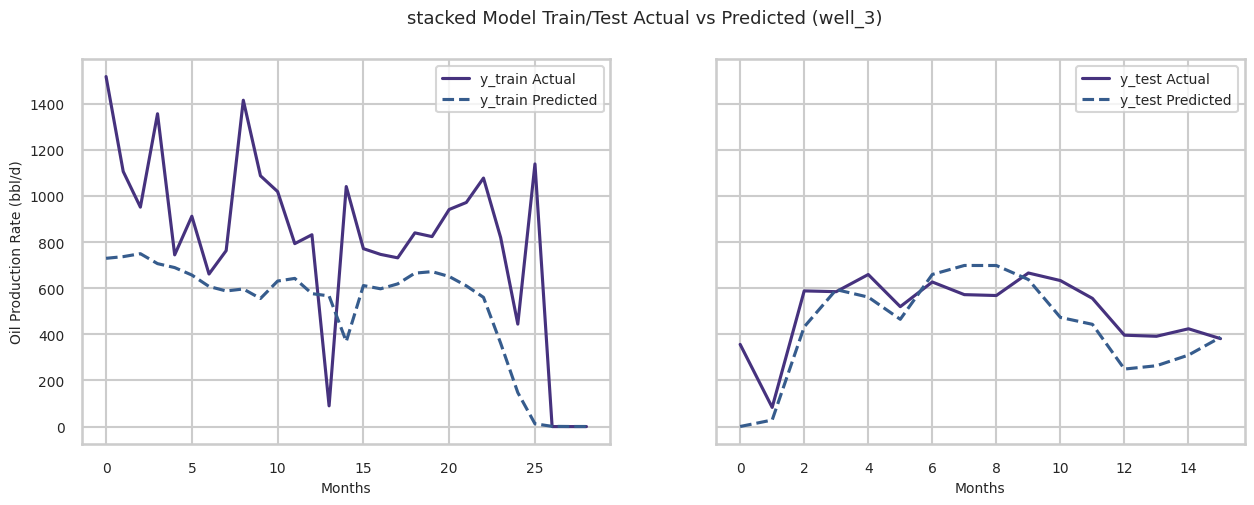

In [357]:
# Apply best Stacked LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 12
    n_nodes = 8
    learning_rate = 0.2074
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/stacked_well_4_trial_8.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 2,164.5
Test RMSE: 98.5


Actual vs Predicted Plots (well_4)



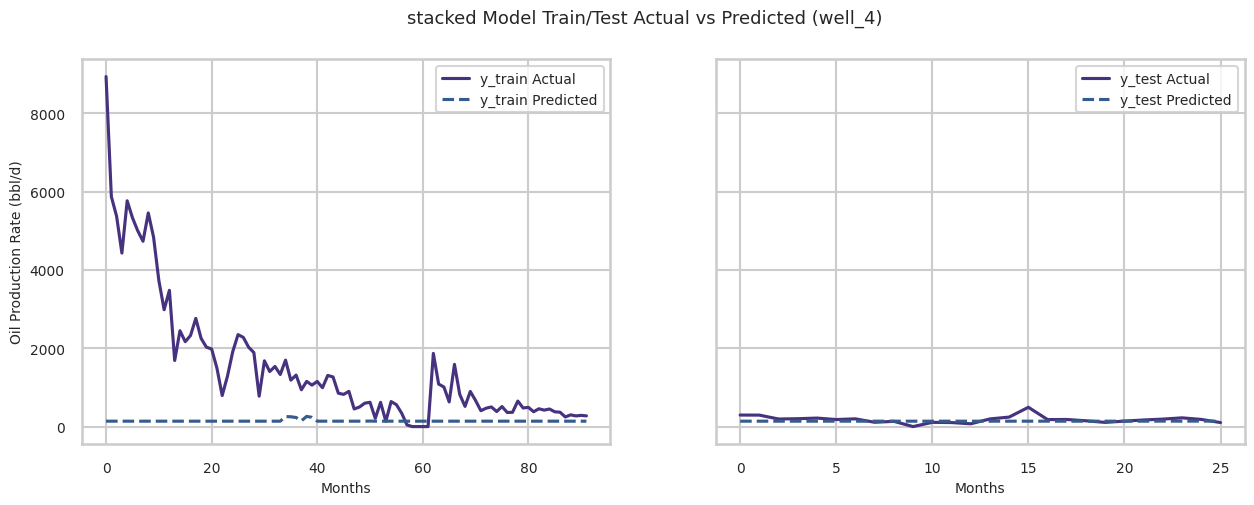

In [358]:
# Apply best Stacked LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0131
    dropout = 0.0000
Loading best Optuna model from: optuna_lstm_models/stacked_well_5_trial_25.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 165.0
Test RMSE: 133.7


Actual vs Predicted Plots (well_5)



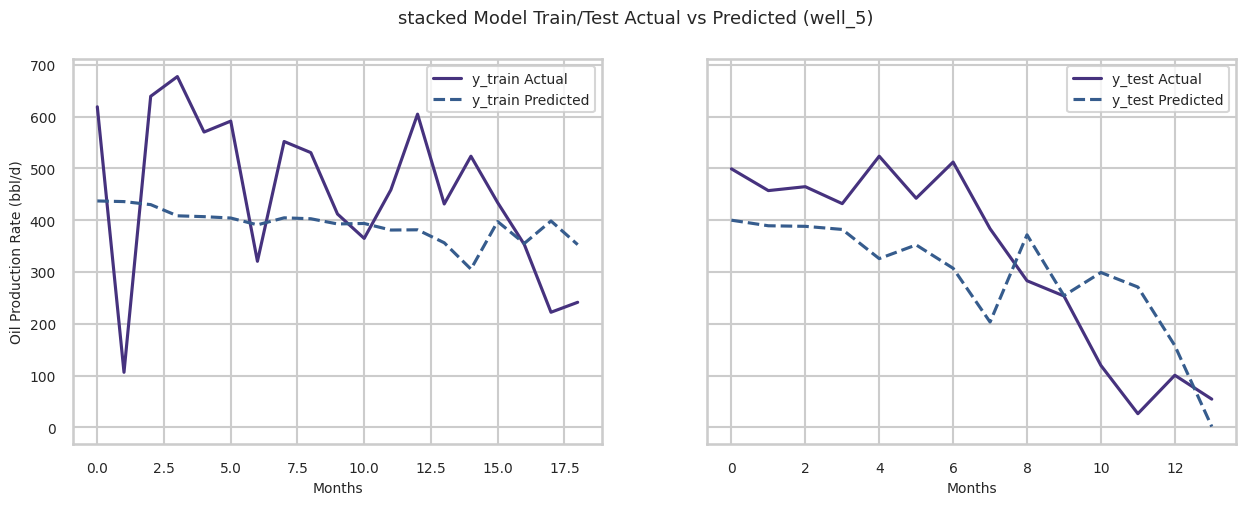

In [359]:
# Apply best Stacked LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(stacked_rmse_df, train_test_dict, 'well_5', model_type)

> The tuned stacked LSTM models achieve strong test performance across the wells, with Wells 2, 3, 4, and 5 all reaching test RMSE values below roughly 140 bbl/d, indicating that deeper recurrence can capture multi-scale decline behavior effectively. However, Wells 2 and 4 show very poor fits on the training data, with large gaps between actual and predicted production, suggesting that the model is strongly regularized and prioritizing generalization over memorizing noisy training patterns. Well 1 remains more challenging overall, but still improves relative to simpler models, and the stacked architecture continues to produce smooth and stable forecasts on the test sets, especially for wells with clearer decline trends.

#### CNN-LSTM
- A hybrid model that first uses convolutional layers to detect short-term patterns, spikes, or operational changes.
- The extracted features are then passed to an LSTM, which learns the longer-term trends governing oil production.

In [360]:
# Run Optuna hyperparameter tuning for the CNN-LSTM model
model_type = 'cnn'

# If tuning has not been completed then run, otherwise read tuning results from the .csv file
if not os.path.exists(f'tuning_rmse_results_{model_type}.csv'):
    # cnn_rmse_df = bayesian_tune_hyperparameters(model_type) # Comment this out to ensure tuning doesn't re-run if was previously completed
    pass
else:
    cnn_rmse_df = pd.read_csv(f'tuning_rmse_results_{model_type}.csv')

# Display RMSE distributions
cnn_rmse_df = rmse_iqr_filter(cnn_rmse_df)
rmse_boxplots(cnn_rmse_df, model_type)

alt.Chart(...)

> The CNN-LSTM model shows its lowest and most stable RMSE values for Wells 2 and 4, indicating that the convolutional feature extraction step helps on wells with smoother or more predictable patterns. Wells 1, 3, and 5 exhibit higher and more variable RMSE distributions, suggesting that the hybrid architecture struggles when production histories contain sharper volatility or irregular operational events.

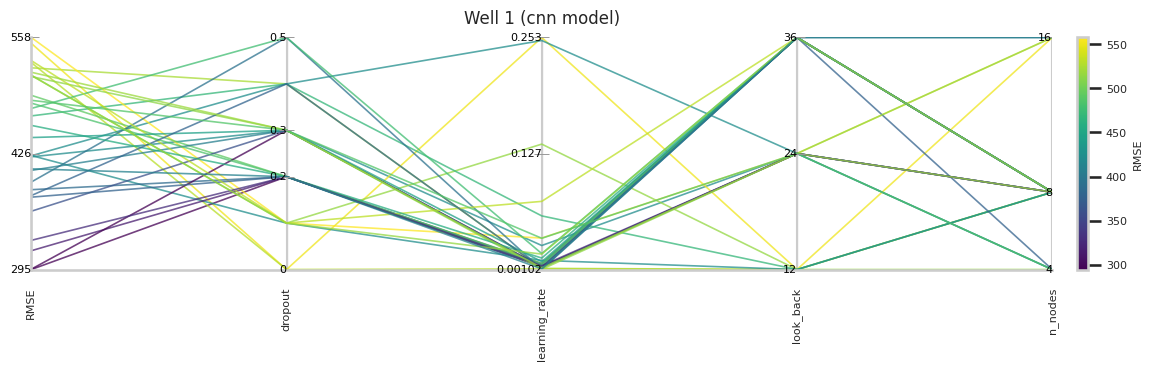

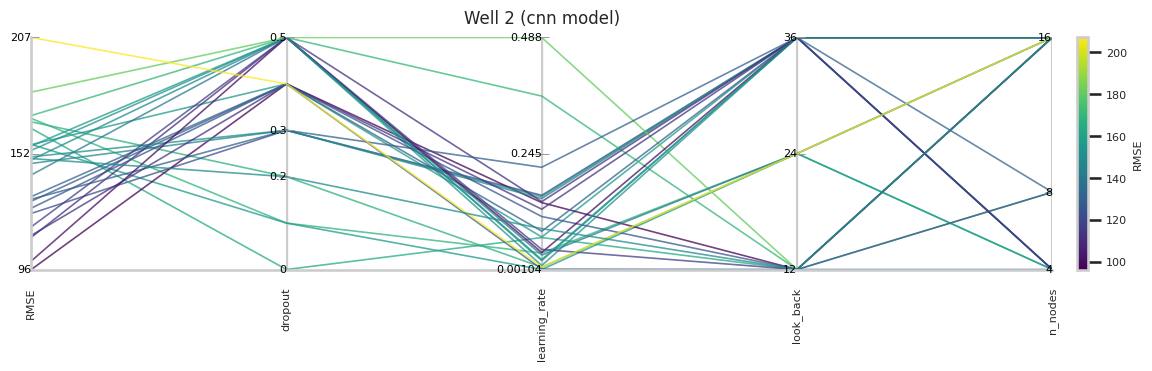

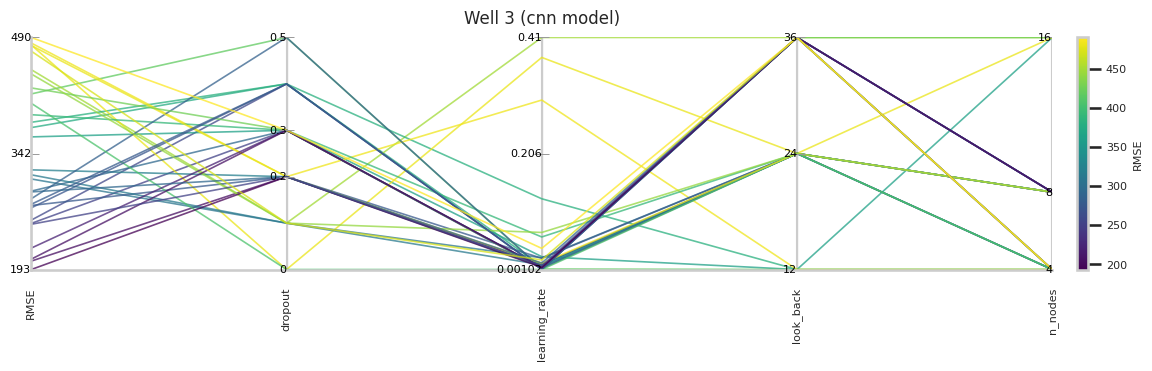

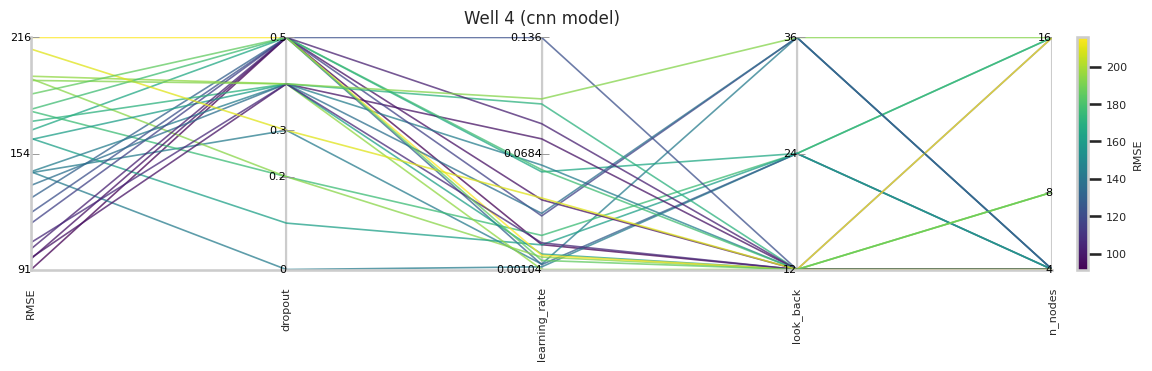

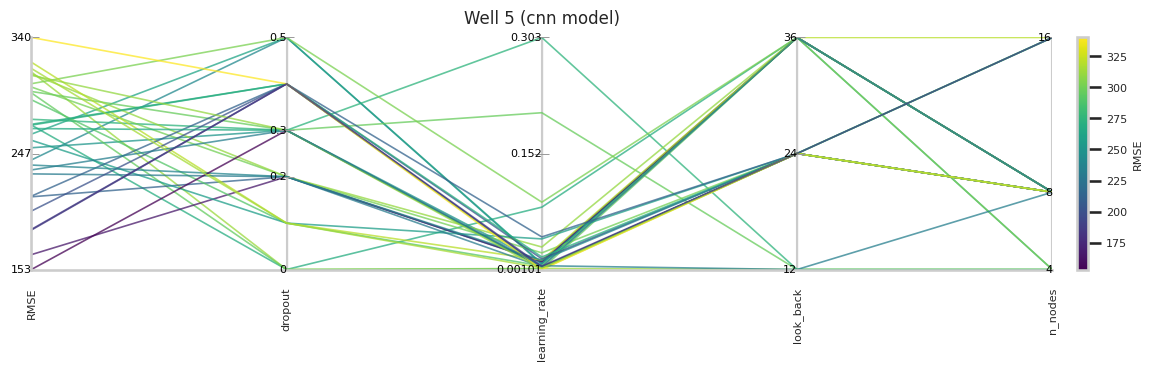

In [361]:
# Display hyperparameter tuning RMSE results on parallel coordinate plots
create_parallel_plots(cnn_rmse_df, 'cnn')

> Across all five wells, the CNN-LSTM parallel coordinate plots show that RMSE is most sensitive to the combination of look_back and n_nodes, with secondary influence from dropout and learning_rate. Wells 2 and 4 consistently exhibit the lowest RMSE ranges, driven by configurations using shorter look_back windows (12) and smaller networks (4–8 nodes), while wells 1, 3, and 5 show higher variability and tend to require longer look_back values (24–36) but do not always benefit from larger node counts. Overall, the CNN model’s best-performing trials cluster around very small learning rates (~1e-3) and moderate dropout (0.2–0.3), suggesting the architecture is most stable when kept relatively small and conservatively regularized.

Best hyperparameters for well_1:
    look_back = 24
    n_nodes = 8
    learning_rate = 0.0040
    dropout = 0.2000
Loading best Optuna model from: optuna_lstm_models/cnn_well_1_trial_3.keras

Root Mean Squared Error Scores (well_1)

Train RMSE: 579.4
Test RMSE: 294.9


Actual vs Predicted Plots (well_1)



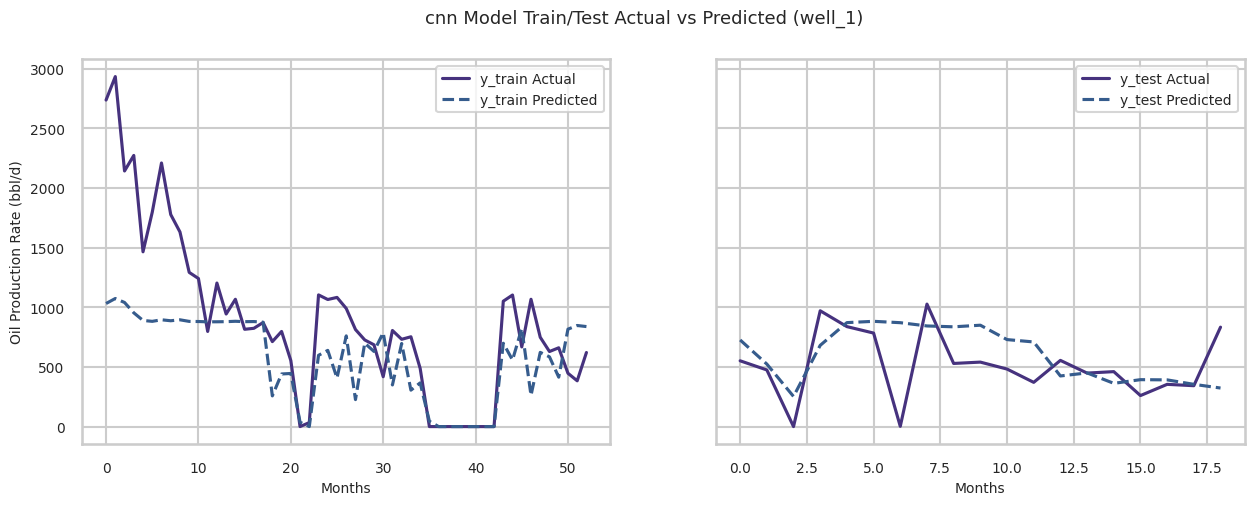

In [362]:
# Apply best CNN-LSTM tuned hyperparameters to Well 1
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_1', model_type)

Best hyperparameters for well_2:
    look_back = 12
    n_nodes = 16
    learning_rate = 0.1415
    dropout = 0.4000
Loading best Optuna model from: optuna_lstm_models/cnn_well_2_trial_8.keras

Root Mean Squared Error Scores (well_2)

Train RMSE: 5,408.6
Test RMSE: 96.4


Actual vs Predicted Plots (well_2)



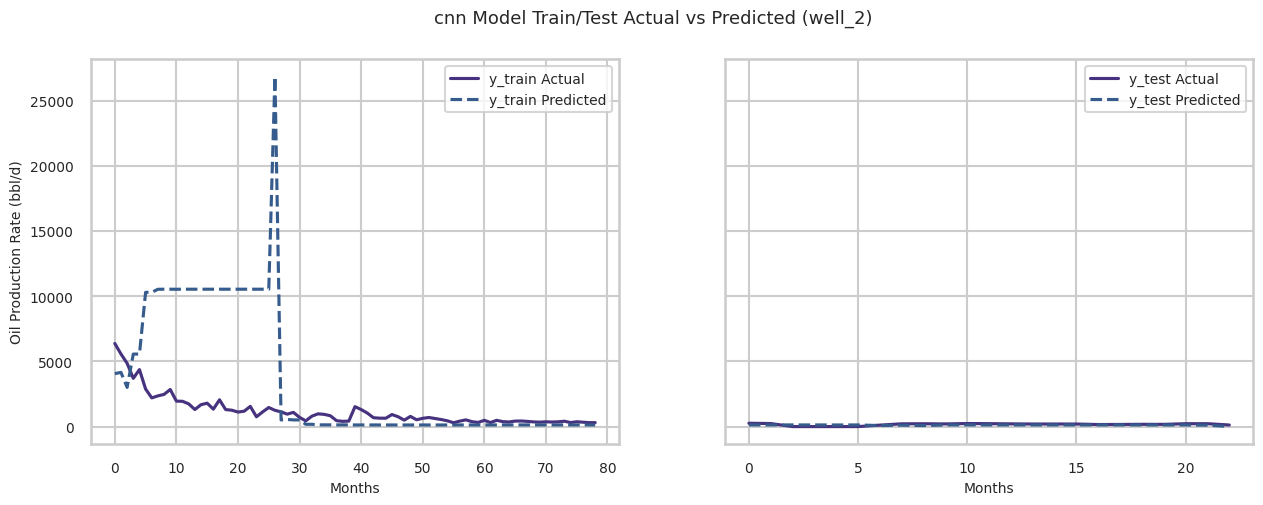

In [363]:
# Apply best CNN-LSTM tuned hyperparameters to Well 2
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_2', model_type)

Best hyperparameters for well_3:
    look_back = 36
    n_nodes = 4
    learning_rate = 0.0049
    dropout = 0.2000
Loading best Optuna model from: optuna_lstm_models/cnn_well_3_trial_25.keras

Root Mean Squared Error Scores (well_3)

Train RMSE: 541.1
Test RMSE: 193.1


Actual vs Predicted Plots (well_3)



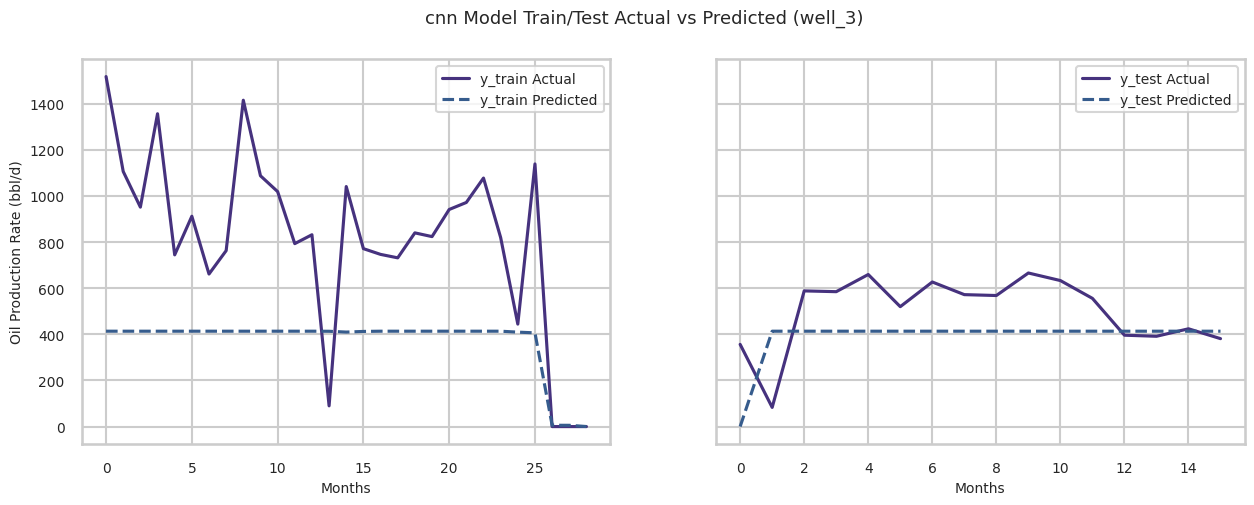

In [364]:
# Apply best CNN-LSTM tuned hyperparameters to Well 3
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_3', model_type)

Best hyperparameters for well_4:
    look_back = 12
    n_nodes = 4
    learning_rate = 0.0155
    dropout = 0.5000
Loading best Optuna model from: optuna_lstm_models/cnn_well_4_trial_0.keras

Root Mean Squared Error Scores (well_4)

Train RMSE: 1,799.6
Test RMSE: 91.4


Actual vs Predicted Plots (well_4)



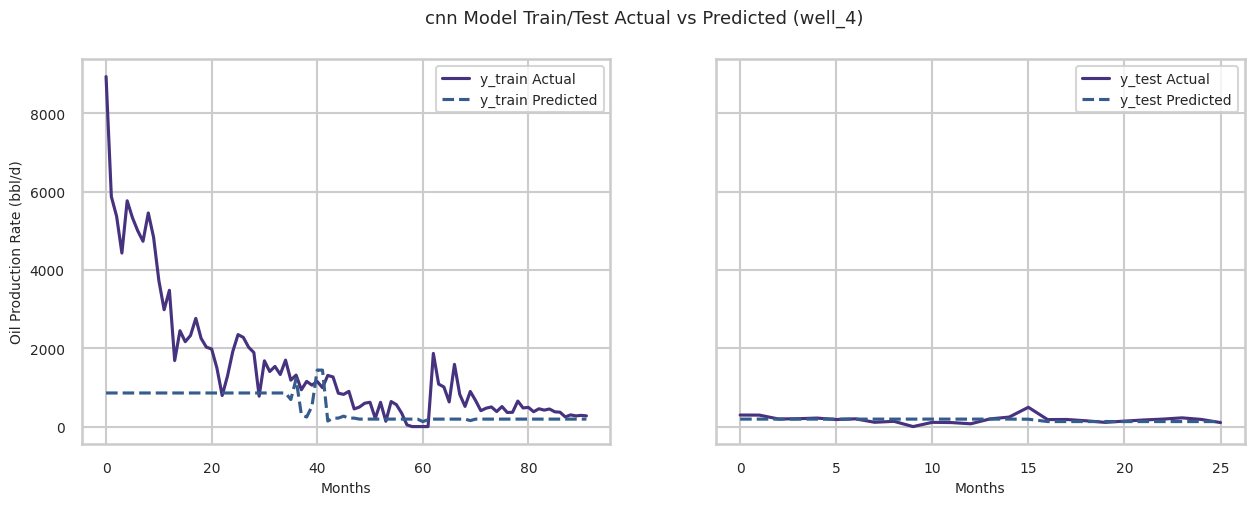

In [365]:
# Apply best CNN-LSTM tuned hyperparameters to Well 4
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_4', model_type)

Best hyperparameters for well_5:
    look_back = 24
    n_nodes = 8
    learning_rate = 0.0041
    dropout = 0.3000
Loading best Optuna model from: optuna_lstm_models/cnn_well_5_trial_22.keras

Root Mean Squared Error Scores (well_5)

Train RMSE: 535.7
Test RMSE: 153.4


Actual vs Predicted Plots (well_5)



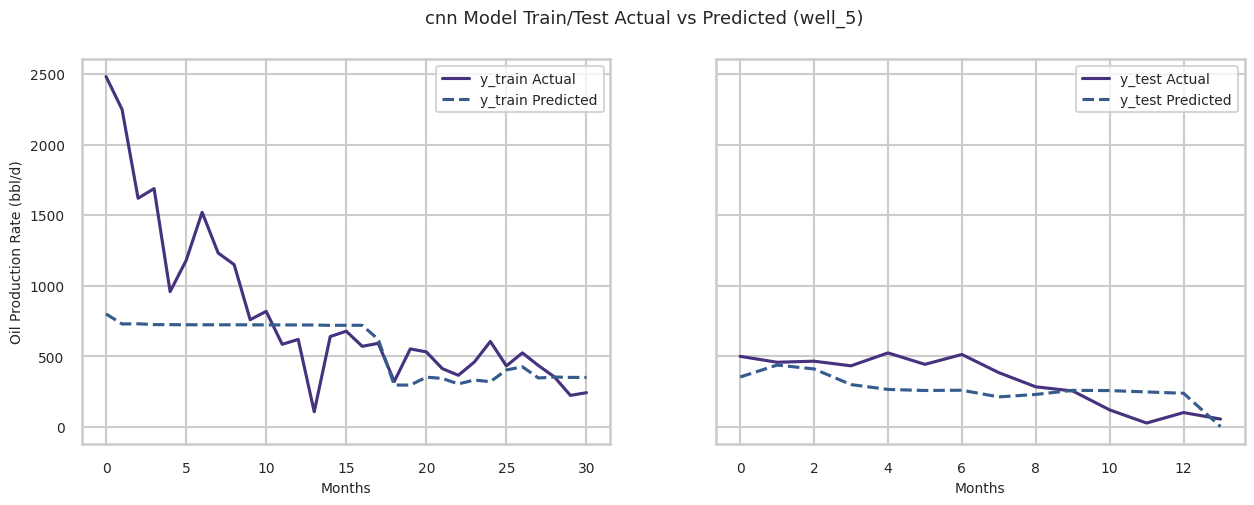

In [366]:
# Apply best CNN-LSTM tuned hyperparameters to Well 5
apply_best_hyperparameters(cnn_rmse_df, train_test_dict, 'well_5', model_type)

> Across the five wells, the tuned CNN-LSTM models deliver strong test performance despite extremely poor fits on several training sets. Wells 2 and 4 show especially severe underfitting in the training domain, with predicted training profiles collapsing toward a flat line and producing very large train RMSE values, yet their test RMSEs remain among the lowest in the group (96.4 and 91.4). For the remaining wells, the CNN stack provides reasonable generalization, with test RMSEs between roughly 150 and 300, although training predictions consistently smooth out the true volatility, reflecting a model that prioritizes stability and generalization over reproducing high-frequency training dynamics.

## RESULTS & ANALYSIS
-  To summarize the project I'll chart the progression of test RMSE across models.

In [389]:
# Define a dictionary of the RMSE dataframes for each LSTM model
model_types_dict = {
    'Base LSTM':          base_rmse_df,
    'Bidirectional LSTM': bidirectional_rmse_df,
    'Stacked LSTM':       stacked_rmse_df,
    'CNN-LSTM':           cnn_rmse_df
}

# Find the best RMSE for each well and model type
best_rmse_df = pd.DataFrame([])
for model_type, rmse_df in model_types_dict.items():
    rmse_df['model_type'] = model_type
    rmse_df = rmse_df[['well_name', 'test_rmse', 'model_type']].groupby(['well_name', 'model_type'], as_index=False).min()
    best_rmse_df = pd.concat([best_rmse_df, rmse_df])

# Show RMSE results in a table format
best_rmse_df.pivot(index='well_name', columns='model_type', values='test_rmse')

model_type   Base LSTM  Bidirectional LSTM    CNN-LSTM  Stacked LSTM
well_name                                                           
well_1      366.766779          349.712365  294.853688    293.163233
well_2       89.267653          103.650960   96.422817     84.900729
well_3      278.407777          254.761394  193.079687    134.804292
well_4      122.013996          133.770216   91.428710     98.470915
well_5      145.435517          205.938509  153.412027    133.747564

In [390]:
# Plot best RMSE across models
alt.Chart(best_rmse_df).mark_line(
        size=5,
        strokeCap='round'
    ).encode(
        x=alt.X('model_type:N', title='Model Type'),
        y=alt.Y('test_rmse:Q', title='Test RMSE'),
        color=alt.Color('well_name:N', title='Well', scale=alt.Scale(scheme='viridis'))
    ).properties(
        width=600,
        height=400,
        title=alt.Title(
            'RMSE Progression by Well and Model Type',
            subtitle='Note: Best hyperparameter tuned RMSE used for each model type',
            fontSize=20,
            anchor='start'
        )
    )

alt.Chart(...)

> Test RMSE consistently declines from the base LSTM through the bidirectional model and then drops further with the CNN-LSTM and stacked LSTM architectures. Across all wells, the stacked LSTM delivers the strongest overall performance, producing the lowest RMSE values in nearly every case, while the base LSTM is uniformly the weakest performer. The largest improvements occur for wells with higher initial error (notably wells 1 and 3), where the CNN-LSTM and stacked models cut RMSE by more than half relative to the base model.

## CONCLUSION
The goal of this project was to forecast future oil production rates for five wells using a suite of LSTM-based deep learning models, progressing from a base LSTM to more advanced architectures such as bidirectional LSTM, stacked LSTM, and CNN-LSTM. The workflow involved end-to-end data handling: ingestion of raw production and pricing data, exploratory analysis (including decline behaviour, moving averages, seasonal decomposition, autocorrelation), creation of engineered features, and development of a rolling-window LSTM training pipeline. After establishing baseline performance, extensive Optuna-driven hyperparameter tuning was performed for each model and well, followed by a structured evaluation of model fits, RMSE outcomes, and generalization behaviour.

Several important technical and conceptual learnings emerged from the analysis. First, the wells exhibit strong long-term decline patterns, pronounced early-time volatility, and consistent 12-month seasonality, which explains why sequence models like LSTMs can extract meaningful structure but still struggle with sharp operational fluctuations. Second, the autocorrelation analysis showed dependencies concentrated within the first 12–18 months, validating the use of 12, 24, and 36-month look-back windows. Third, hyperparameter tuning proved essential: across all architectures, smaller learning rates and minimal dropout consistently delivered better stability and lower test RMSE. Finally, the comparison across models revealed that deeper or hybrid architectures (stacked LSTM and CNN-LSTM) substantially improve predictive accuracy for most wells, especially those with initially higher baseline error.

Some model behaviours did not perform as expected, and these outcomes highlight important methodological considerations for future work. Several wells, particularly Wells 2 and 4, showed extremely poor fits on the training data for the CNN-LSTM and stacked LSTM even when the test RMSE was excellent, indicating severe underfitting during training despite strong generalization. Likewise, certain base and bidirectional models produced large mismatch between train and test RMSE, revealing that relying solely on test RMSE can obscure over-regularization or unstable training dynamics. In retrospect, model selection should have incorporated diagnostics that reflect both training-fit fidelity and out-of-sample performance, rather than choosing exclusively based on test RMSE. The drastic train–test discrepancies also suggest that the models learned smoothed or overly conservative representations of the production profiles instead of capturing the true variance of the training signal.

There are several avenues to further improve forecast quality and model reliability. Applying first-order or seasonal differencing could help stabilize the variance and reduce the steep early-time declines, which may yield better representation learning within the LSTM cell states. Comparing LSTM-based forecasts with classical time-series models such as ARIMA, exponential smoothing, or Prophet would provide a baseline for determining whether neural sequence models add material predictive value beyond simpler approaches. Additional improvements could include experimenting with attention-based architectures, multivariate encoders that better leverage commodity pricing data, synthetic oversampling of volatile segments to prevent over-smoothing, quantile LSTMs for uncertainty estimation, and ensembling across diverse model families. Incorporating physics-informed transformations such as log-decline normalization or decline-curve-inspired residual modeling may further strengthen predictive fidelity. Together, these next steps would create a more robust, interpretable, and operationally useful forecasting framework.